### 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
# This will ignore the warnings
import warnings
warnings.filterwarnings("ignore")
from collections import Counter

import seaborn as sns; sns.set()

### 2. Data preparation and cleanup

In [2]:
# Read the data from CSV
data = pd.read_csv('./amazon_reviews_us_Toys_v1_00.tsv',delimiter='\t',error_bad_lines=False, warn_bad_lines=False)

In [3]:
# Make required columns string type
data['product_title'] = data['product_title'].astype(str)
data['review_headline'] = data['review_headline'].astype(str)
data['review_body'] = data['review_body'].astype(str)

In [4]:
# Remove unnecessary columns
data.drop(['product_category','marketplace'], inplace=True, axis=1)

In [5]:
# Lenghly refined toy categories (not perfect, but as far as we can get right now)

all_toy_categories=['Arts,Crafts-Art,Craft,Adhesive,Apron,Smock,Clay,Dough,Craft,Painting,Drawing,Easel,Fuse,Perler,Bead,Pipe,Printing,Stamping,Scissor,Sticker',
                    'Baby,Toddler-Baby,Toddler,Activity,Center,Bath,Car,Seat,Stroller,Push,Pull,Rattle,Horse,Teether',
                    'Building-Building,Gear,Marble,Stacking,Blocks',
                    'Collectible-Collectible,Collectibles,Display,Statue,Bobblehead,Bust',
                    'Dolls-Doll,Dollhouse,Dollhouses,Dolls',
                    'Dress,Pretend-Dress,Beauty,Fashion,Costume,Hat,Mask,Pretend,Wigs',
                    'Games-Arcade,Table,Board,Card,Cards,Dice,Floor,Game,Gaming,Tile,Games',
                    'Hobbies-Hobbies,Coin,Collecting,Hobby,Tools,Hardware,Models,Model,Pinewood,Rocket,Stamp',
                    'Electronics-Electronics,Gadget,Dance,Mat,DVD,Electronic,Handheld,Karaoke,MP3,Video,Player,Plug,Remote,Controlled,Robot,Walkie,Talkies,Channel,Radio,Infrared,Drone,2.4GHz,Batteries',
                    'Furniture,Décor,Storage-Backpack,Lunch,Box,Bedding,Slumber,Furniture,Room,Décor,Decor,Chest,Storage,Table,Bag',
                    'Learning,Education-Education,Counting,Math,Learning,Geographic,Globe,Habitat,Musical,Instrument,Optic,Reading,Writing,Rock,Tumbler,Science,Solar,Power,Kits,Book',
                    'Novelty,Gag-Fidget,Spinner,Fortune,Telling,Gag,Practical,Joke,Juggling,Magic,Magnets,Magnetic,Miniatures,Money,Banks,Novelty,Nesting,Spinning,Prism,Kaleidoscope,Slime,Putty,Spy,Viewfinder,Yo yo',
                    'Party-Balloon,Banner,Birthday,Candle,Cake,Cupcake,Toppers,Centerpiece,Noisemaker,Party,Favor,Pack,Tableware,Piñata,Pinata,Tablecover,Foam,Bubbles',
                    'Vehicles-Die Cast,Vehicles,Train,Railway,Vehicle,Car,Race,Tracks',
                    'Puppets,Puppet,Theaters-Finger,Puppets,Hand,Marionette,Puppet,Theater,Ventriloquist',
                    'Puzzles-3D,Brain,Teaser,Jigsaw,Pegged,Puzzle,Sudoku,Puzzles',
                    'Sports,Outdoor-Bike,Ball,Pit,Footbag,Water Blaster,Fitness,Flying,Gardening,Inflatable,Bouncer,Kickball,Playground,Ball,Kite,Wind,Nature,Outdoor,Tent,Playhouse,Pogo,Hopper,Pool,Sand,Sandboxe,Sport,Trampoline',
                    'Stuffed,Animals,Plush-Plush,Interactive,Animal,Stuffed,Animals,Teddy,Teddy Bear',
                    'Figures,Playsets-Action,Figure,Playset',
                    'Tricycles,Scooters,Wagons-Balance Bike,Bike,Helmet,Pedal,Ride,Ride On,Wagon,Scooter,Tricycle,Skateboard,Skate,Unicycle'
                   ]

In [6]:
# Special words that should be excluded from the search logic
excluded_keywords = [
'&',
'and',
'by',
'-',
'the'
]

# This function returns already clean category in one step
# Function that returns category given a product_title
def get_category(keywords):
    global all_toy_categories
    if isinstance(keywords, list):
        for keyword in keywords:
            if not keyword.lower() in excluded_keywords:
                for category in all_toy_categories:
                    if keyword.lower() in category.lower():
                        return category.strip().split('-')[0] # cut off redundant stuff right here
    return 'Others'

In [7]:
# Split only product_title into an array
data['split_title'] = data['product_title'].str.split()

In [10]:
# Run function to categories each toy
data['category'] = data['split_title'].apply(get_category)

In [11]:
# Checking how grouped data looks like for further analysis
grouped = data.groupby(by='category')
grouped.size().sort_values(ascending=False)

category
Others                       1096860
Arts,Crafts                   386135
Electronics                   337585
Figures,Playsets              304668
Games                         301732
Learning,Education            259999
Baby,Toddler                  255061
Novelty,Gag                   250693
Party                         246925
Sports,Outdoor                207380
Stuffed,Animals,Plush         195621
Furniture,Décor,Storage       160952
Dress,Pretend                 160249
Dolls                         144495
Hobbies                       125183
Collectible                    94773
Vehicles                       91994
Puzzles                        76882
Building                       72275
Puppets,Puppet,Theaters        61263
Tricycles,Scooters,Wagons      28882
dtype: int64

In [12]:
# Pickup columns that are of concern
review_data = data[['customer_id','product_id','product_title','category','star_rating','helpful_votes','total_votes','vine','verified_purchase','review_headline','review_body','review_date']]
review_data.shape

(4859607, 12)

In [13]:
# get valid & non-valid review_date
import re

def get_date(date):
    if re.search('([12]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[12]\d|3[01]))', date):
        return date
    return None

In [14]:
review_data['review_date'] = review_data['review_date'].astype(str).apply(get_date)

In [15]:
review_data['review_date'].isnull().sum()

29

In [16]:
review_data.dropna(inplace=True)

In [17]:
review_data['review_date'] = pd.to_datetime(review_data['review_date'], format='%Y-%m-%d')

In [18]:
review_data.shape

(4859578, 12)

In [19]:
# Data cleanup: Consider only verified purchases
review_data = review_data[review_data['verified_purchase']=='Y']
review_data.shape

(4017933, 12)

In [20]:
# Data cleanup: Drop others category
review_data = review_data[~review_data['category'].str.contains("Others")]
review_data.shape

(3130350, 12)

In [19]:
investment = [{'Type': 'Arts,Crafts',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Baby,Toddler',  'Large': 1, 'Over_1kg': 1, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Building',  'Large': 0, 'Over_1kg': 1, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Collectible',  'Large': 1, 'Over_1kg': 1, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Dolls',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Dress,Pretend',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Games',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Hobbies',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 1, 'Electronics':1}, 
              {'Type': 'Electronics',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':1}, 
              {'Type': 'Furniture,Décor,Storage',  'Large': 1, 'Over_1kg': 1, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Learning,Education',  'Large': 1, 'Over_1kg': 0, 'Mechanism': 1, 'Electronics':0}, 
              {'Type': 'Novelty,Gag',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 1, 'Electronics':0}, 
              {'Type': 'Party',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Vehicles',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 1, 'Electronics':1}, 
              {'Type': 'Puppets,Puppet,Theaters',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Puzzles',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Sports,Outdoor',  'Large': 1, 'Over_1kg': 1, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Stuffed,Animals,Plush',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Figures,Playsets',  'Large': 0, 'Over_1kg': 0, 'Mechanism': 0, 'Electronics':0}, 
              {'Type': 'Tricycles,Scooters,Wagons',  'Large': 1, 'Over_1kg': 1, 'Mechanism': 1, 'Electronics':1}, 
             ]

In [20]:
# Investment categories
df_investment = pd.DataFrame(investment, columns =['Type', 'Large', 'Over_1kg', 'Mechanism', 'Electronics'])
df_investment['Summary'] = df_investment.sum(axis=1)
df_investment.loc[df_investment['Summary'] == 0, 'associated_expenses'] = 'low'
df_investment.loc[df_investment['Summary'] > 0, 'associated_expenses'] = 'medium'
df_investment.loc[df_investment['Summary'] > 1, 'associated_expenses'] = 'high'
df_investment

,Type,Large,Over_1kg,Mechanism,Electronics,Summary,associated_expenses
0,"Arts,Crafts",0,0,0,0,0,low
1,"Baby,Toddler",1,1,0,0,2,high
2,Building,0,1,0,0,1,medium
3,Collectible,1,1,0,0,2,high
4,Dolls,0,0,0,0,0,low
5,"Dress,Pretend",0,0,0,0,0,low
6,Games,0,0,0,0,0,low
7,Hobbies,0,0,1,1,2,high
8,Electronics,0,0,0,1,1,medium
9,"Furniture,Décor,Storage",1,1,0,0,2,high


In [21]:
df_investment_a_e=df_investment[['Type','associated_expenses']]
df_investment_a_e=df_investment_a_e.set_index(['Type'])
df_investment_a_e

,associated_expenses
Type,
"Arts,Crafts",low
"Baby,Toddler",high
Building,medium
Collectible,high
Dolls,low
"Dress,Pretend",low
Games,low
Hobbies,high
Electronics,medium


In [22]:
# Add counter column for easier summation
review_data['counter']= 1.0
review_data.head()

,customer_id,product_id,product_title,category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,counter
0,18778586,B00EDBY7X8,Monopoly Junior Board Game,Games,5.0,0.0,0.0,N,Y,Five Stars,Excellent!!!,2015-08-31,1.0
1,24769659,B00D7JFOPC,56 Pieces of Wooden Train Track Compatible wit...,Vehicles,5.0,0.0,0.0,N,Y,Good quality track at excellent price,Great quality wooden track (better than some o...,2015-08-31,1.0
2,44331596,B002LHA74O,Super Jumbo Playing Cards by S&S Worldwide,Games,2.0,1.0,1.0,N,Y,Two Stars,Cards are not as big as pictured.,2015-08-31,1.0
3,23310293,B00ARPLCGY,Barbie Doll and Fashions Barbie Gift Set,Dolls,5.0,0.0,0.0,N,Y,my daughter loved it and i liked the price and...,my daughter loved it and i liked the price and...,2015-08-31,1.0
4,38745832,B00UZOPOFW,Emazing Lights eLite Flow Glow Sticks - Spinni...,"Novelty,Gag",1.0,1.0,1.0,N,Y,DONT BUY THESE!,Do not buy these! They break very fast I spun ...,2015-08-31,1.0


In [23]:
# Total items per category
total_cat=review_data.groupby('category').counter.sum().sort_values(ascending = False)#.head(10)
total_star_cat=pd.DataFrame(data=total_cat)
total_star_cat

,counter
category,
"Arts,Crafts",326713.0
Electronics,275776.0
"Figures,Playsets",253223.0
Games,248240.0
"Novelty,Gag",212492.0
Party,207571.0
"Baby,Toddler",206010.0
"Learning,Education",205530.0
"Stuffed,Animals,Plush",168882.0


In [24]:
# No. of times a category recieved more than a 4 star review
star_45= review_data[review_data['star_rating']>=4.0]
top_cat=star_45.groupby('category').counter.sum().sort_values(ascending = False)#.head(10)
star_45_top_cat=pd.DataFrame(data=top_cat)
star_45_top_cat.rename(columns={'counter': '4_or_more_stars_recieved'}, inplace=True)
star_45_top_cat

,4_or_more_stars_recieved
category,
"Arts,Crafts",266626.0
Electronics,211452.0
"Figures,Playsets",210365.0
Games,205215.0
"Baby,Toddler",170766.0
"Learning,Education",164734.0
"Novelty,Gag",160212.0
Party,157813.0
"Stuffed,Animals,Plush",144935.0


In [25]:
# No. of times a category recieved less = a 2 star review
star_21= review_data[review_data['star_rating']<=2.0]
low_cat=star_21.groupby('category').counter.sum().sort_values(ascending = False)#.head(10)
star_21_low_cat=pd.DataFrame(data=low_cat)
star_21_low_cat.rename(columns={'counter': '2_or_less_stars_recieved'}, inplace=True)
star_21_low_cat

,2_or_less_stars_recieved
category,
Electronics,41509.0
"Arts,Crafts",34436.0
"Novelty,Gag",32778.0
Party,31443.0
Games,26434.0
"Sports,Outdoor",25899.0
"Learning,Education",24262.0
"Figures,Playsets",23860.0
"Dress,Pretend",20900.0


In [26]:
# Merging average rating percentage and associated expenses dataframe
merge=pd.concat([total_star_cat, star_45_top_cat, star_21_low_cat],axis=1)
merge['success %age']= merge['4_or_more_stars_recieved']/merge['counter']*100
merge['fail %age']= merge['2_or_less_stars_recieved']/merge['counter']*100
merge.index.names = ['Category']
df_investment_a_e.index.names = ['Category']
merge_all=pd.concat([merge,df_investment_a_e],axis=1)
merge_all.head()

,counter,4_or_more_stars_recieved,2_or_less_stars_recieved,success %age,fail %age,associated_expenses
"Arts,Crafts",326713.0,266626.0,34436.0,81.608629,10.540138,low
"Baby,Toddler",206010.0,170766.0,20467.0,82.892093,9.934955,high
Building,59829.0,50451.0,5307.0,84.325327,8.870280,medium
Collectible,79254.0,64120.0,8749.0,80.904434,11.039190,high
Dolls,120722.0,105472.0,8150.0,87.367671,6.751048,low


### 3. Data validation and sanity tests

In [21]:
# Custom functions for running grouping logic
def one_rating_count(series):
    count = 0
    for v in series:
        if v == 1:
            count = count + 1
    return count
def two_rating_count(series):
    count = 0
    for v in series:
        if v == 2:
            count = count + 1
    return count
def three_rating_count(series):
    count = 0
    for v in series:
        if v == 3:
            count = count + 1
    return count
def four_rating_count(series):
    count = 0
    for v in series:
        if v == 4:
            count = count + 1
    return count
def five_rating_count(series):
    count = 0
    for v in series:
        if v == 5:
            count = count + 1
    return count
def count_yes(series):
    count = 0
    for v in series:
        if v == 'Y':
            count = count + 1
    return count
def avg_len(series):
    sum = 0
    for v in series:
        if isinstance(v, str):
            sum = sum + len(v)            
    return sum/series.size

In [22]:
# Group by customer id and check patterns for customer reviews
grouped_rev_data = review_data.groupby(by='customer_id').agg({'star_rating': {'avg_rating':'mean',
                                                                                              'one': one_rating_count,
                                                                                              'two': two_rating_count,
                                                                                              'three': three_rating_count,
                                                                                              'four': four_rating_count,
                                                                                              'five': five_rating_count
                                                                                             }, 
                                                                              'review_date': {'num_of_revs':'count'},
                                                                              'category': {'category_count': 'nunique'},
                                                                              'helpful_votes': {'avg_help_votes': 'mean'},
                                                                              'vine': {'vine_count': count_yes},
                                                                              'verified_purchase': {'verified_pur_count': count_yes},
                                                                              'review_body': {'len_rev_body': avg_len}
                                                                             })
grouped_rev_data.head()

star_rating                            review_date       category  \
             avg_rating  one  two three four  five num_of_revs category_count   
customer_id                                                                     
10082               5.0  0.0  0.0   0.0  0.0   1.0           1              1   
10085               5.0  0.0  0.0   0.0  0.0   1.0           1              1   
10092               5.0  0.0  0.0   0.0  0.0   1.0           1              1   
10096               5.0  0.0  0.0   0.0  0.0   1.0           1              1   
10120               5.0  0.0  0.0   0.0  0.0  13.0          13              3   

             helpful_votes       vine  verified_purchase  review_body  
            avg_help_votes vine_count verified_pur_count len_rev_body  
customer_id                                                            
10082             0.000000          0                  1         21.0  
10085             2.000000          0                  1        189.0  
10092             0.000000          0                  1         33.0  
10096             0.000000          0                  1        105.0  
10120             1.692308          0                 13        283.0

In [23]:
grouped_rev_data.columns = grouped_rev_data.columns.droplevel(level=0)
grouped_rev_data.head()

,avg_rating,one,two,three,four,five,num_of_revs,category_count,avg_help_votes,vine_count,verified_pur_count,len_rev_body
customer_id,,,,,,,,,,,,
10082,5.0,0.0,0.0,0.0,0.0,1.0,1,1,0.000000,0,1,21.0
10085,5.0,0.0,0.0,0.0,0.0,1.0,1,1,2.000000,0,1,189.0
10092,5.0,0.0,0.0,0.0,0.0,1.0,1,1,0.000000,0,1,33.0
10096,5.0,0.0,0.0,0.0,0.0,1.0,1,1,0.000000,0,1,105.0
10120,5.0,0.0,0.0,0.0,0.0,13.0,13,3,1.692308,0,13,283.0


In [30]:
# Group by product id and check patterns for product reviews
product_rev_data = review_data.groupby(by='product_id').agg({'star_rating': {'avg_rating':'mean',
                                                                                              'one': one_rating_count,
                                                                                              'two': two_rating_count,
                                                                                              'three': three_rating_count,
                                                                                              'four': four_rating_count,
                                                                                              'five': five_rating_count
                                                                                             }, 
                                                                              'review_date': {'num_of_revs':'count'},
                                                                              'category': {'category_count': 'nunique'},
                                                                              'helpful_votes': {'avg_help_votes': 'mean',
                                                                                                'tot_help_votes': 'sum'
                                                                                               },
                                                                              'total_votes': {'avg_tot_votes': 'mean',
                                                                                              'tot_tot_votes': 'sum'
                                                                                             },
                                                                              'vine': {'vine_count': count_yes},
                                                                              'verified_purchase': {'verified_pur_count': count_yes},
                                                                              'review_body': {'len_rev_body': avg_len}
                                                                             })
product_rev_data.head()

star_rating                           review_date       category  \
            avg_rating  one  two three four five num_of_revs category_count   
product_id                                                                    
0000031887        4.25  0.0  0.0   1.0  1.0  2.0           4              1   
0000037214        1.00  1.0  0.0   0.0  0.0  0.0           1              1   
0000191639        5.00  0.0  0.0   0.0  0.0  1.0           1              1   
0005069491        4.00  0.0  0.0   0.0  1.0  0.0           1              1   
0006466222        5.00  0.0  0.0   0.0  0.0  1.0           1              1   

            helpful_votes                  total_votes                \
           avg_help_votes tot_help_votes avg_tot_votes tot_tot_votes   
product_id                                                             
0000031887            0.0            0.0           0.0           0.0   
0000037214            1.0            1.0           1.0           1.0   
0000191639            0.0            0.0           0.0           0.0   
0005069491            0.0            0.0           0.0           0.0   
0006466222            0.0            0.0           0.0           0.0   

                 vine  verified_purchase  review_body  
           vine_count verified_pur_count len_rev_body  
product_id                                             
0000031887          0                  4        94.25  
0000037214          0                  1       132.00  
0000191639          0                  1       125.00  
0005069491          0                  1       653.00  
0006466222          0                  1         2.00

In [31]:
product_rev_data.columns = product_rev_data.columns.droplevel(level=0)
product_rev_data.head()

,avg_rating,one,two,three,four,five,num_of_revs,category_count,avg_help_votes,tot_help_votes,avg_tot_votes,tot_tot_votes,vine_count,verified_pur_count,len_rev_body
product_id,,,,,,,,,,,,,,,
0000031887,4.25,0.0,0.0,1.0,1.0,2.0,4,1,0.0,0.0,0.0,0.0,0,4,94.25
0000037214,1.00,1.0,0.0,0.0,0.0,0.0,1,1,1.0,1.0,1.0,1.0,0,1,132.00
0000191639,5.00,0.0,0.0,0.0,0.0,1.0,1,1,0.0,0.0,0.0,0.0,0,1,125.00
0005069491,4.00,0.0,0.0,0.0,1.0,0.0,1,1,0.0,0.0,0.0,0.0,0,1,653.00
0006466222,5.00,0.0,0.0,0.0,0.0,1.0,1,1,0.0,0.0,0.0,0.0,0,1,2.00


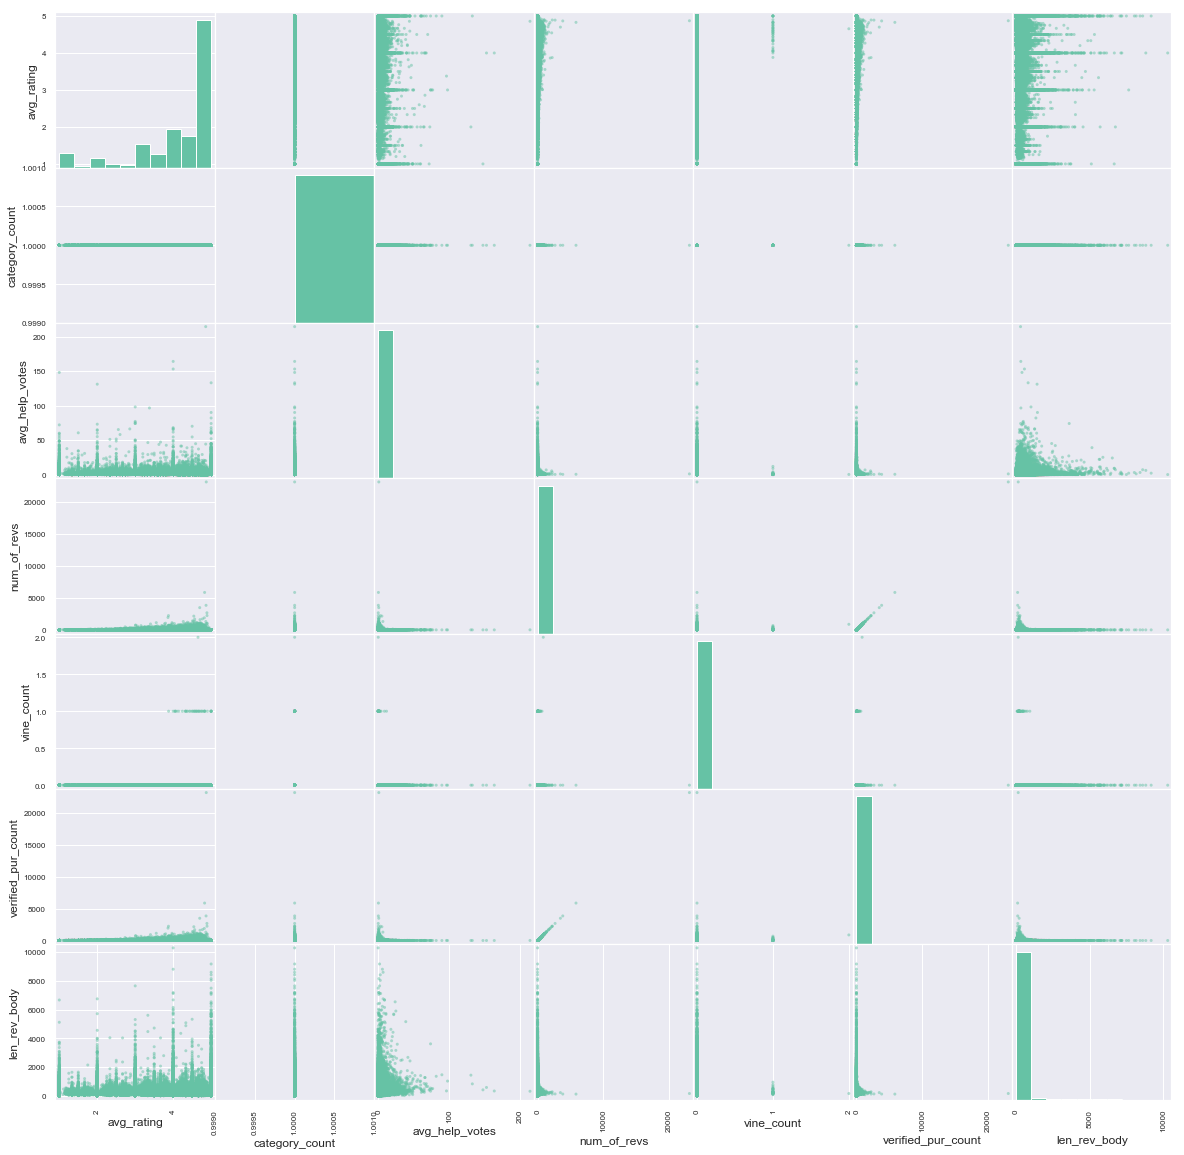

In [240]:
sns.set(rc={'figure.figsize':(20,20)}, palette='Set2')
pd.plotting.scatter_matrix(product_rev_data[['avg_rating',
                                             'category_count',
                                             'avg_help_votes',
                                             'num_of_revs',
                                             'vine_count',
                                             'verified_pur_count',
                                             'len_rev_body']], 
                           diagonal='hist');

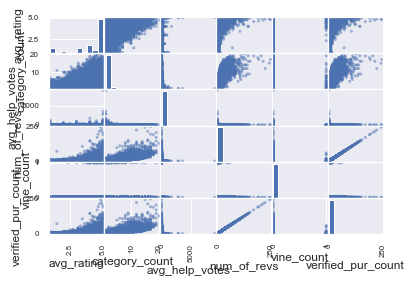

In [24]:
sns.set(rc={'figure.figsize':(20,20)}, palette='Set2')
pd.plotting.scatter_matrix(grouped_rev_data[['avg_rating','category_count','avg_help_votes','num_of_revs','vine_count','verified_pur_count']], diagonal='hist');

### 4. Can a startup product of a non-featured brand be successfull on Amazon

In [34]:
df_investment.set_index('Type')

,Large,Over_1kg,Mechanism,Electronics,Summary,associated_expenses
Type,,,,,,
"Arts,Crafts",0,0,0,0,0,low
"Baby,Toddler",1,1,0,0,2,high
Building,0,1,0,0,1,medium
Collectible,1,1,0,0,2,high
Dolls,0,0,0,0,0,low
"Dress,Pretend",0,0,0,0,0,low
Games,0,0,0,0,0,low
Hobbies,0,0,1,1,2,high
Electronics,0,0,0,1,1,medium


In [35]:
# Create a Series of 'Type' and 'associated_expenses'
investmentSeries = pd.Series(data= list(df_investment.associated_expenses), index=df_investment.Type)
len(list(investmentSeries.index))

20

In [36]:
# Function to get investment type
def get_investment_kind(category):
    if category in investmentSeries.index:
        return investmentSeries[category]
    return 'not_as_investment'

In [38]:
# Add 'investment' column
if 'investment' in review_data.columns:
    review_data.drop(columns=['investment'])
review_data['investment'] = review_data.category.apply(get_investment_kind)

In [39]:
review_data.head()

,customer_id,product_id,product_title,category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,counter,investment
0,18778586,B00EDBY7X8,Monopoly Junior Board Game,Games,5.0,0.0,0.0,N,Y,Five Stars,Excellent!!!,2015-08-31,1.0,low
1,24769659,B00D7JFOPC,56 Pieces of Wooden Train Track Compatible wit...,Vehicles,5.0,0.0,0.0,N,Y,Good quality track at excellent price,Great quality wooden track (better than some o...,2015-08-31,1.0,high
2,44331596,B002LHA74O,Super Jumbo Playing Cards by S&S Worldwide,Games,2.0,1.0,1.0,N,Y,Two Stars,Cards are not as big as pictured.,2015-08-31,1.0,low
3,23310293,B00ARPLCGY,Barbie Doll and Fashions Barbie Gift Set,Dolls,5.0,0.0,0.0,N,Y,my daughter loved it and i liked the price and...,my daughter loved it and i liked the price and...,2015-08-31,1.0,low
4,38745832,B00UZOPOFW,Emazing Lights eLite Flow Glow Sticks - Spinni...,"Novelty,Gag",1.0,1.0,1.0,N,Y,DONT BUY THESE!,Do not buy these! They break very fast I spun ...,2015-08-31,1.0,medium


In [40]:
# Check if there is any not_as_investment entries 
review_data[review_data.investment=='not_as_investment'].loc[:, ['category','investment']].groupby('category').size().sum()

0

In [41]:
# categoies' size and dropping Others category's entries 
review_data.groupby('category').size().sort_values(ascending=False)

category
Arts,Crafts                  326713
Electronics                  275776
Figures,Playsets             253223
Games                        248240
Novelty,Gag                  212492
Party                        207571
Baby,Toddler                 206010
Learning,Education           205530
Stuffed,Animals,Plush        168882
Sports,Outdoor               167316
Dress,Pretend                139692
Furniture,Décor,Storage      137546
Dolls                        120722
Hobbies                      106378
Collectible                   79254
Vehicles                      74333
Puzzles                       66421
Building                      59829
Puppets,Puppet,Theaters       50922
Tricycles,Scooters,Wagons     23500
dtype: int64

## So far...

- Droping the non-verfied purchase's rows 
- Droping non-valid review_date's rows
- Adding *'category'* columns and labeling products with their close categories based on their product_titles
- Adding *'investment'* columns and labeling products with their investment levels based on their categories
- Droping 'Others' category and related rows 

### What are main competitors for top branded toys? How about non_popular branded toys??

### Analyze Top Branded Toys 

#### 1) Create a list of top branded toys from 1998 to 2015

In [42]:
# Top 25 toys brand based on Brandirectory.com (Brand Finance Directory) web site for year 2015
# https://brandirectory.com/rankings/toys-25-2015

brandFinance_25top = ['lego','fisher-price', 'barbie', 'mattel', 'nerf', 'playskool', 'hasbro',
                      'mobile suit gundam', 'power rangers', 'monopoly', 'monster high', 'bandai namco',
                      'hot wheels', 'mega bloks', 'play-doh', 'ben 10', 'my little pony', 'star wars',
                      'transformers', 'masked rider', 'bandai', 'magic: the gathering', 'magic the gathering',
                      'littlest pet shop', 'leapforg', 'matchbox']

In [43]:
# Top 18 toys barnd from 1998 to 2015 based on Insider.com and Pocket-lint.com
# https://www.insider.com/popular-christmas-toys-2016-12#2010-ipad-26
# https://www.pocket-lint.com/parenting/news/142866-the-most-popular-christmas-toys-and-tech-from-over-the-last-40-years

insider_pocketLint_18top = ['furby', 'pokemon', 'razor scooter', 'brazt doll', 'brazt', 'beyblades', 'robosapien',
               'xbox 360', 'playstation 3', 'nintendo ds', 'nintendo wii', 'nook', 'zhu zhu pet', 
               'leapPad explorer', 'wii u', 'big hugs elmo', 'let\'s rock elmo', 'elsa doll']

In [44]:
# 22 featured berand based on Amazon.com 
amazon_featured_brands = ['baby alive','barbie','beyblade','disney','fisher-price','funko',
                          'gund','hatchimals','hot wheels','kidkraft','learning resources',
                          'lego','little tikes','l.o.l surprise' , 'melissa & doug','nerf',
                          'osmo','play-doh','playmobil','playskool','radio flyer' ,'ravensburger']

In [45]:
# Concatinate all lists together --> top_brands list 
top_brands = list(set().union(brandFinance_25top,insider_pocketLint_18top, amazon_featured_brands))
len(top_brands)

59

#### 2) Labeled products with their brand

##### 2-1) Create a new column as 'brand' and labeled products based on *top_brands* list 

In [46]:
# Function to check a product belonges to top brand groups or not (ntb = not_top_branded)

def get_brand(product,brand_list, brand_name):
    for brand in brand_list:
        if brand in product.lower():
            brand_name = brand
            break
    return brand_name        

In [47]:
def drop_col(data_frame, col):
    if col in data_frame.columns: 
        data_frame.drop(columns=[col], inplace=True)
    return data_frame    

In [48]:
# Create a new column on dataframe named 'brand'
if 'brand' in review_data.columns: 
    review_data.drop(columns=['brand'])
    
review_data['brand'] = review_data.product_title.astype(str).apply(get_brand,args=[top_brands,'ntb']) # ntb = non_top_branded 

In [49]:
review_data.head()

,customer_id,product_id,product_title,category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,counter,investment,brand
0,18778586,B00EDBY7X8,Monopoly Junior Board Game,Games,5.0,0.0,0.0,N,Y,Five Stars,Excellent!!!,2015-08-31,1.0,low,monopoly
1,24769659,B00D7JFOPC,56 Pieces of Wooden Train Track Compatible wit...,Vehicles,5.0,0.0,0.0,N,Y,Good quality track at excellent price,Great quality wooden track (better than some o...,2015-08-31,1.0,high,ntb
2,44331596,B002LHA74O,Super Jumbo Playing Cards by S&S Worldwide,Games,2.0,1.0,1.0,N,Y,Two Stars,Cards are not as big as pictured.,2015-08-31,1.0,low,ntb
3,23310293,B00ARPLCGY,Barbie Doll and Fashions Barbie Gift Set,Dolls,5.0,0.0,0.0,N,Y,my daughter loved it and i liked the price and...,my daughter loved it and i liked the price and...,2015-08-31,1.0,low,barbie
4,38745832,B00UZOPOFW,Emazing Lights eLite Flow Glow Sticks - Spinni...,"Novelty,Gag",1.0,1.0,1.0,N,Y,DONT BUY THESE!,Do not buy these! They break very fast I spun ...,2015-08-31,1.0,medium,ntb


##### 2-2) Find most frequent brands based on number of reviews in the dataset --> final_top_brands

In [50]:
review_data.groupby(['brand']).size().sort_values(ascending=False)

brand
ntb                     2354798
disney                   135044
melissa & doug           102715
fisher-price              60532
lego                      53663
barbie                    39788
star wars                 35103
pokemon                   27468
monster high              25515
funko                     24836
little tikes              19044
learning resources        18738
nerf                      17951
hot wheels                17007
gund                      16330
bandai                    16263
my little pony            14975
transformers              14671
playskool                 13810
kidkraft                  13106
radio flyer               12427
ravensburger              11709
magic the gathering        8599
mattel                     7432
mega bloks                 7356
magic: the gathering       6759
power rangers              5673
littlest pet shop          5197
monopoly                   4985
playmobil                  4963
play-doh                   4340
ha

***Note:*** Based on the above result, we do Not consider brands with ***less that 500 reviews***, and dismiss them as top brands.

In [51]:
# Find less frequesnt top brands on Amazon dataset
brands_sizeSeries = review_data.groupby('brand').size()
indexes = brands_sizeSeries.index
values = brands_sizeSeries.values

less_frequent_brands = []
for index, value in zip(indexes, values):
    if value < 500: 
        less_frequent_brands.append(index)

In [52]:
# 10 less frequent brands based on database reviews 
less_frequent_brands 

['big hugs elmo',
 "let's rock elmo",
 'masked rider',
 'nintendo ds',
 'nintendo wii',
 'playstation 3',
 'razor scooter',
 'robosapien',
 'wii u']

In [53]:
final_top_brands = [item for item in top_brands if item not in less_frequent_brands]
len(final_top_brands)

50

##### Edit 'brand' columns based on *final_top_brands* list

In [54]:
if 'brand' in review_data.columns: 
    review_data.drop(columns=['brand'])
    
review_data['brand'] = review_data.product_title.astype(str).apply(get_brand,args=[final_top_brands,'ntb']) # ntb = non_top_branded

In [55]:
review_data.groupby(['brand']).size().sort_values(ascending=False)

brand
ntb                     2355845
disney                   135044
melissa & doug           102715
fisher-price              60532
lego                      53665
barbie                    39788
star wars                 35103
pokemon                   27468
monster high              25515
funko                     24836
little tikes              19044
learning resources        18738
nerf                      17951
hot wheels                17007
bandai                    16342
gund                      16330
my little pony            14975
transformers              14671
playskool                 14148
kidkraft                  13106
radio flyer               12427
ravensburger              11709
magic the gathering        8599
mattel                     7432
mega bloks                 7356
magic: the gathering       6759
power rangers              5673
littlest pet shop          5200
monopoly                   4985
playmobil                  4963
play-doh                   4340
ha

In [56]:
# number of all branded products 
review_data[review_data.brand!='ntb'].shape

(774505, 15)

##### Create a sub-df for top-branded toys 

In [57]:
top_branded_df = review_data[review_data.brand!='ntb']

In [58]:
top_branded_df.shape

(774505, 15)

In [59]:
top_branded_df.groupby(['brand']).size().sort_values(ascending=False)

brand
disney                  135044
melissa & doug          102715
fisher-price             60532
lego                     53665
barbie                   39788
star wars                35103
pokemon                  27468
monster high             25515
funko                    24836
little tikes             19044
learning resources       18738
nerf                     17951
hot wheels               17007
bandai                   16342
gund                     16330
my little pony           14975
transformers             14671
playskool                14148
kidkraft                 13106
radio flyer              12427
ravensburger             11709
magic the gathering       8599
mattel                    7432
mega bloks                7356
magic: the gathering      6759
power rangers             5673
littlest pet shop         5200
monopoly                  4985
playmobil                 4963
play-doh                  4340
hasbro                    4316
furby                     3916
ma

##### 2-3) Plot top 10 most frequent top-branded toys based on brand names and number of reviews

In [60]:
top_10brands = top_branded_df.groupby(['brand']).size().sort_values(ascending=False)[:10]
top_10brands

brand
disney            135044
melissa & doug    102715
fisher-price       60532
lego               53665
barbie             39788
star wars          35103
pokemon            27468
monster high       25515
funko              24836
little tikes       19044
dtype: int64

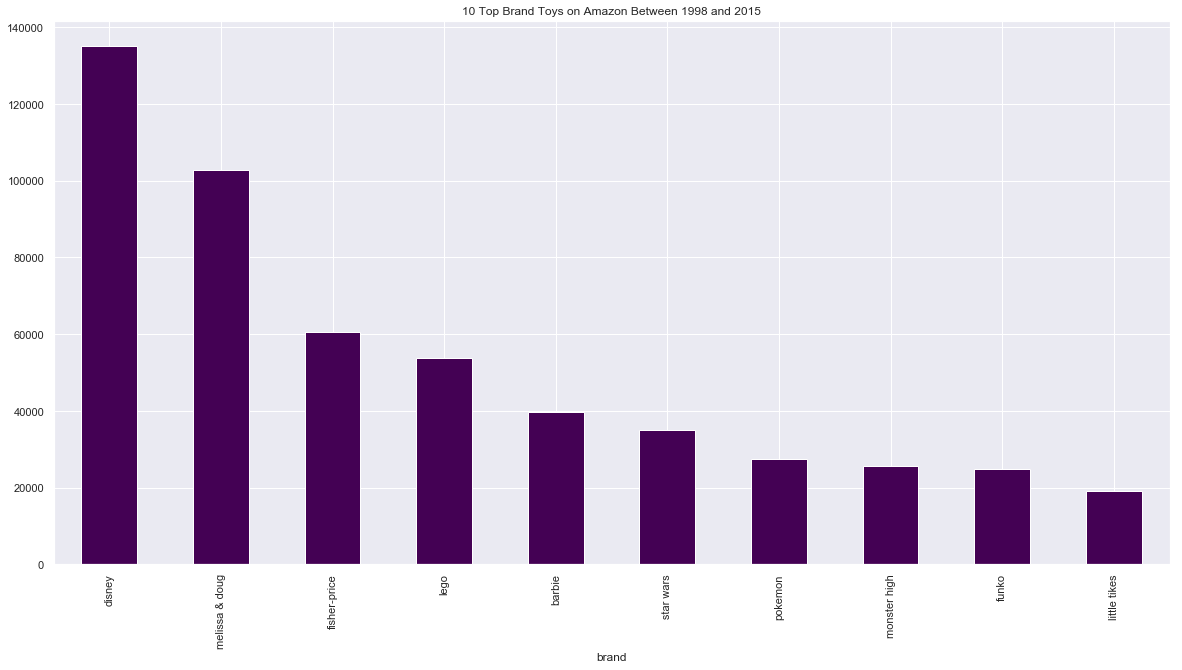

In [61]:
top_10brands.plot(kind='bar', figsize=(20,10),title='10 Top Brand Toys on Amazon Between 1998 and 2015',
                         colormap='viridis');

### Analyze Top Non-popular branded Toys 

In [62]:
review_data[review_data.brand=='ntb'].shape

(2355845, 15)

In [63]:
# Non-popular branded toys based on their product_titles and number of their reviews

review_data[review_data.brand=='ntb'].groupby('product_title').size().sort_values(ascending=False)

product_title
Cards Against Humanity                                                                                                                                                                                23124
Cards Against Humanity: First Expansion                                                                                                                                                                5851
VTech Sit-to-Stand Learning Walker                                                                                                                                                                     4374
Cards Against Humanity: Second Expansion                                                                                                                                                               3838
The Original Stomp Rocket                                                                                                                                                 

#### Create non-popular brand list based on above result

In [64]:
# 10 High most frequent non-popular branded toys 

nonpopular_10brands = ['cards against humanity', 'syma', 'vtech', 'snap circuits', 'stomp rocket',
                     'spot it!', 'udi','accoutrements horse head mask', 'rainbow loom', 'ticket to ride']
len(nonpopular_10brands)

10

##### Create a sub_df for nonpopular brands 

In [65]:
nonpopular_df = review_data[review_data.brand=='ntb']

In [66]:
nonpopular_df.shape

(2355845, 15)

In [67]:
nonpopular_df.head()

,customer_id,product_id,product_title,category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,counter,investment,brand
1,24769659,B00D7JFOPC,56 Pieces of Wooden Train Track Compatible wit...,Vehicles,5.0,0.0,0.0,N,Y,Good quality track at excellent price,Great quality wooden track (better than some o...,2015-08-31,1.0,high,ntb
2,44331596,B002LHA74O,Super Jumbo Playing Cards by S&S Worldwide,Games,2.0,1.0,1.0,N,Y,Two Stars,Cards are not as big as pictured.,2015-08-31,1.0,low,ntb
4,38745832,B00UZOPOFW,Emazing Lights eLite Flow Glow Sticks - Spinni...,"Novelty,Gag",1.0,1.0,1.0,N,Y,DONT BUY THESE!,Do not buy these! They break very fast I spun ...,2015-08-31,1.0,medium,ntb
6,2749569,B0101EHRSM,Big Bang Cosmic Pegasus (Pegasis) Metal 4D Hig...,Party,3.0,2.0,2.0,N,Y,Three Stars,"To keep together, had to use crazy glue.",2015-08-31,1.0,low,ntb
7,41137196,B00407S11Y,Fun Express Insect Finger Puppets 12ct Toy,"Puppets,Puppet,Theaters",5.0,0.0,0.0,N,Y,Five Stars,I was pleased with the product.,2015-08-31,1.0,low,ntb


##### Re-label nonpopular-df entries' brand column based on *nonpopular_brands* list 

In [68]:
if 'brand' in nonpopular_df: 
    nonpopular_df.drop(columns=['brand'])
    
nonpopular_df['brand'] = nonpopular_df.product_title.astype(str).apply(get_brand,args=[nonpopular_10brands,'ntb'])

In [69]:
nonpopular_df.head()

,customer_id,product_id,product_title,category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,counter,investment,brand
1,24769659,B00D7JFOPC,56 Pieces of Wooden Train Track Compatible wit...,Vehicles,5.0,0.0,0.0,N,Y,Good quality track at excellent price,Great quality wooden track (better than some o...,2015-08-31,1.0,high,ntb
2,44331596,B002LHA74O,Super Jumbo Playing Cards by S&S Worldwide,Games,2.0,1.0,1.0,N,Y,Two Stars,Cards are not as big as pictured.,2015-08-31,1.0,low,ntb
4,38745832,B00UZOPOFW,Emazing Lights eLite Flow Glow Sticks - Spinni...,"Novelty,Gag",1.0,1.0,1.0,N,Y,DONT BUY THESE!,Do not buy these! They break very fast I spun ...,2015-08-31,1.0,medium,ntb
6,2749569,B0101EHRSM,Big Bang Cosmic Pegasus (Pegasis) Metal 4D Hig...,Party,3.0,2.0,2.0,N,Y,Three Stars,"To keep together, had to use crazy glue.",2015-08-31,1.0,low,ntb
7,41137196,B00407S11Y,Fun Express Insect Finger Puppets 12ct Toy,"Puppets,Puppet,Theaters",5.0,0.0,0.0,N,Y,Five Stars,I was pleased with the product.,2015-08-31,1.0,low,ntb


In [70]:
nonpopular_df.groupby('brand').size().sort_values(ascending=False)

brand
ntb                              2231589
cards against humanity             39809
vtech                              29101
syma                               21566
udi                                16322
rainbow loom                        5143
ticket to ride                      3793
stomp rocket                        3750
snap circuits                       2290
accoutrements horse head mask       2151
spot it!                             331
dtype: int64

In [71]:
frequent_10nonpopular_brandSeries = nonpopular_df[nonpopular_df.brand!='ntb'].groupby('brand').size().sort_values(ascending=False)
frequent_10nonpopular_brandSeries

brand
cards against humanity           39809
vtech                            29101
syma                             21566
udi                              16322
rainbow loom                      5143
ticket to ride                    3793
stomp rocket                      3750
snap circuits                     2290
accoutrements horse head mask     2151
spot it!                           331
dtype: int64

##### Plot top 10 most frequent nonpopular-branded toys based on brand names and number of reviews


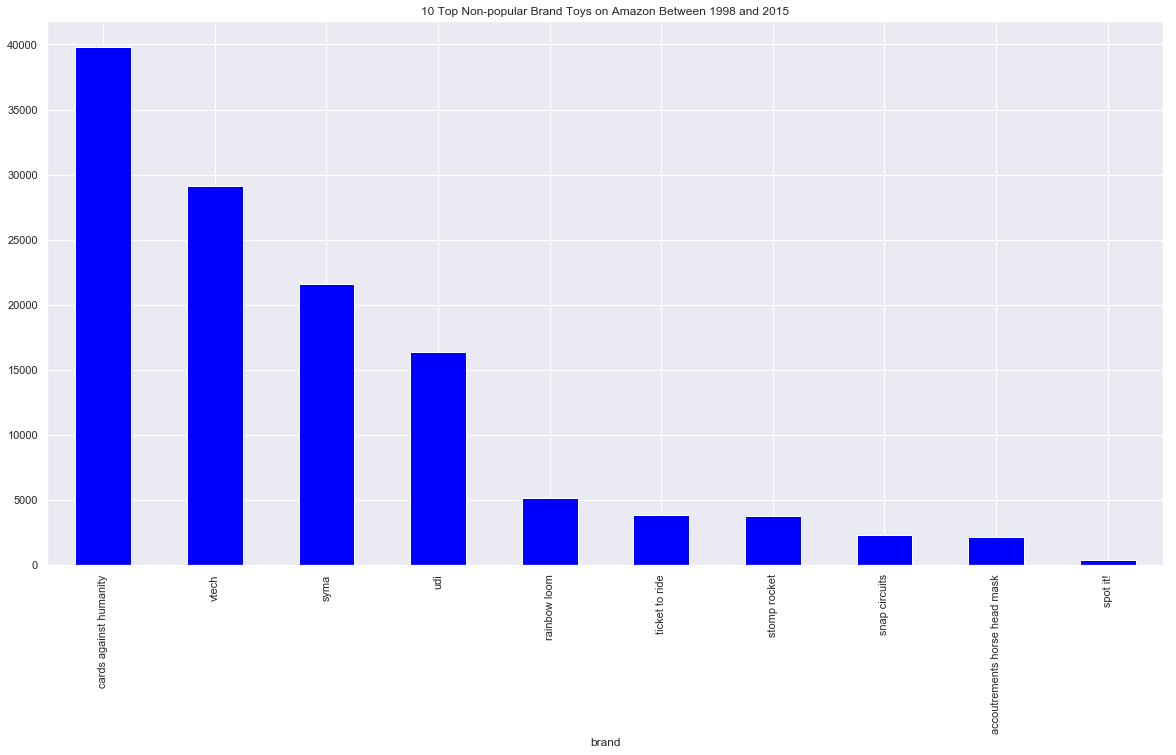

In [72]:
frequent_10nonpopular_brandSeries.plot(kind='bar', figsize=(20,10),title='10 Top Non-popular Brand Toys on Amazon Between 1998 and 2015',
                         colormap='brg');

### Analyze market share based on product categories for 10 top-branded and 10 nonpopular-branded Toys 

#### Groupby whole dataset based on categories & brand names --> 🤔🤔🤔


In [228]:
review_data.groupby(['category','brand']).size().sort_values(ascending=False)

category                   brand             
Electronics                ntb                   223136
Games                      ntb                   218011
Arts,Crafts                ntb                   189276
Novelty,Gag                ntb                   185937
Party                      ntb                   170462
Baby,Toddler               ntb                   164642
Figures,Playsets           ntb                   163260
Learning,Education         ntb                   137550
Sports,Outdoor             ntb                   134954
Stuffed,Animals,Plush      ntb                   130962
Dress,Pretend              ntb                   113357
Arts,Crafts                melissa & doug        102057
Furniture,Décor,Storage    ntb                    98554
Hobbies                    ntb                    89635
Dolls                      ntb                    65903
Collectible                ntb                    64393
Puzzles                    ntb                    58869
Ve

##### 1) Group top branded toys based on categories

In [229]:
top_branded_df.groupby('category').size().sort_values(ascending=False)

category
Arts,Crafts                  137437
Figures,Playsets              89963
Learning,Education            67980
Dolls                         54819
Electronics                   52640
Baby,Toddler                  41368
Furniture,Décor,Storage       38992
Stuffed,Animals,Plush         37920
Party                         37109
Sports,Outdoor                32362
Games                         30229
Novelty,Gag                   26555
Dress,Pretend                 26335
Vehicles                      25204
Building                      22429
Hobbies                       16743
Collectible                   14861
Puppets,Puppet,Theaters        9572
Puzzles                        7552
Tricycles,Scooters,Wagons      4435
dtype: int64

In [230]:
# High rating top branded toys
top_branded_df[top_branded_df.star_rating>=4].groupby('category').size().sort_values(ascending=False)

category
Arts,Crafts                  117971
Figures,Playsets              76075
Learning,Education            56921
Dolls                         48662
Electronics                   42842
Baby,Toddler                  35090
Stuffed,Animals,Plush         32757
Furniture,Décor,Storage       32364
Party                         30381
Sports,Outdoor                26600
Games                         24905
Vehicles                      21689
Novelty,Gag                   21631
Building                      20475
Dress,Pretend                 20133
Hobbies                       14468
Collectible                   12402
Puppets,Puppet,Theaters        8045
Puzzles                        6316
Tricycles,Scooters,Wagons      3698
dtype: int64

##### 2) Group non-popular branded toys based on categories

In [231]:
nonpopular_df.groupby('category').size().sort_values(ascending=False)

category
Electronics                  223136
Games                        218011
Arts,Crafts                  189276
Novelty,Gag                  185937
Party                        170462
Baby,Toddler                 164642
Figures,Playsets             163260
Learning,Education           137550
Sports,Outdoor               134954
Stuffed,Animals,Plush        130962
Dress,Pretend                113357
Furniture,Décor,Storage       98554
Hobbies                       89635
Dolls                         65903
Collectible                   64393
Puzzles                       58869
Vehicles                      49129
Puppets,Puppet,Theaters       41350
Building                      37400
Tricycles,Scooters,Wagons     19065
dtype: int64

In [232]:
# High rating nonpopular toys
nonpopular_df[nonpopular_df.star_rating>=4].groupby('category').size().sort_values(ascending=False)

category
Games                        180310
Electronics                  168610
Arts,Crafts                  148655
Novelty,Gag                  138581
Baby,Toddler                 135676
Figures,Playsets             134290
Party                        127432
Stuffed,Animals,Plush        112178
Learning,Education           107813
Sports,Outdoor               100443
Dress,Pretend                 83804
Furniture,Décor,Storage       77874
Hobbies                       70849
Dolls                         56810
Collectible                   51718
Puzzles                       47073
Vehicles                      39584
Puppets,Puppet,Theaters       33775
Building                      29976
Tricycles,Scooters,Wagons     15417
dtype: int64

##### 3) Plot market share

In [233]:
labels = list(top_branded_df.groupby('category').size().index)
branded_toys = top_branded_df[top_branded_df.star_rating>=4].groupby('category').size().values
nonpopulare_toys = nonpopular_df[nonpopular_df.star_rating>=4].groupby('category').size().values

In [234]:
len(branded_toys)

20

In [235]:
len(nonpopulare_toys)

20

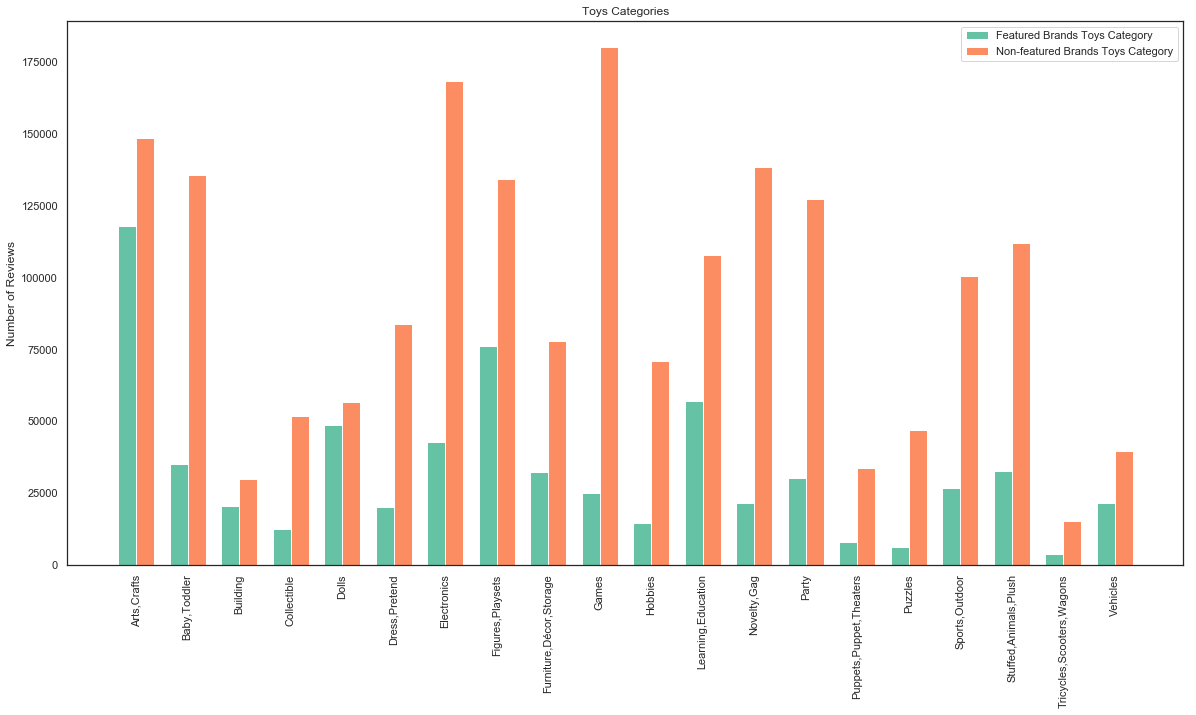

In [239]:
x = np.arange(len(labels))  
width = 0.35  # the width of the bars

sns.set(style="white", palette="Set2", color_codes=True)
fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, branded_toys, width, label='Featured Brands Toys Category')
rects2 = ax.bar(x + width/2, nonpopulare_toys, width, label='Non-featured Brands Toys Category')

ax.set_ylabel('Number of Reviews')
ax.set_title('Toys Categories')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()

plt.show()

### How did customers' preferences change over time for low-investment toys / medium-investment toys / high-investment toys?

In [82]:
import datetime 
start = pd.datetime(1997,1,5)
end = pd.datetime(2018,8,31)

In [83]:
# Select the last business quarter of each year

timerange = pd.date_range(start, end, freq='BM')
timerange

DatetimeIndex(['1997-01-31', '1997-02-28', '1997-03-31', '1997-04-30',
               '1997-05-30', '1997-06-30', '1997-07-31', '1997-08-29',
               '1997-09-30', '1997-10-31',
               ...
               '2017-11-30', '2017-12-29', '2018-01-31', '2018-02-28',
               '2018-03-30', '2018-04-30', '2018-05-31', '2018-06-29',
               '2018-07-31', '2018-08-31'],
              dtype='datetime64[ns]', length=260, freq='BM')

In [84]:
review_data['year'] = review_data['review_date'].dt.year

In [85]:
review_data.year.isnull().sum()

0

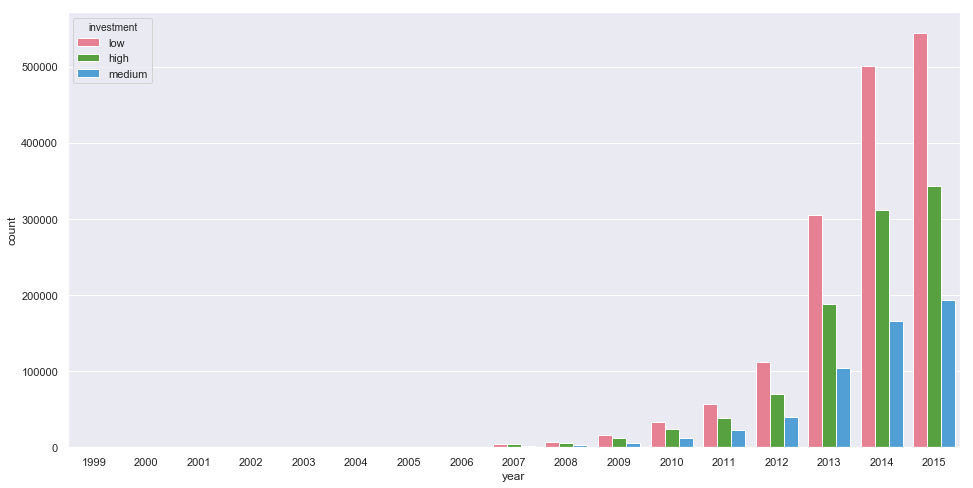

In [224]:
cmap = plt.get_cmap('Set2')
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
sns.countplot(x="year", hue="investment", data=review_data, ax=ax, palette='husl');

### 5. Favorable products

In [87]:
# Number of unique products in dataset
len(review_data['product_title'].unique())

448002

#### Count popularity of products assumed by number of reviews

In [88]:
review_data.columns

Index(['customer_id', 'product_id', 'product_title', 'category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'counter',
       'investment', 'brand', 'year'],
      dtype='object')

In [89]:
pop = pd.DataFrame(review_data['product_title'].value_counts())
pop['title_count'] = pop['product_title']
pop['product_title'] = pop.index
pop.reset_index(inplace=True, drop=True)

In [90]:
pop.head(20)

,product_title,title_count
0,Cards Against Humanity,23124
1,Melissa & Doug,9947
2,Cards Against Humanity: First Expansion,5851
3,VTech Sit-to-Stand Learning Walker,4374
4,Cards Against Humanity: Second Expansion,3838
5,The Original Stomp Rocket,2681
6,Cards Against Humanity: Third Expansion,2667
7,Cards Against Humanity: Fourth Expansion,2236
8,UDI U818A 2.4GHz 4 CH 6 Axis Gyro RC Quadcopte...,2227
9,Mega Bloks 80-Piece Big Building Bag,2199


In [91]:
# add popularity as a column to data
df = pd.merge(review_data, pop, how='inner', on=['product_title'])

In [92]:
df.shape

(3130350, 17)

#### Count of categories in Top 100 product titles

In [93]:
# Overall number of product titles:
print('Number of unique product titles in refind dataset:\n{}'.format(len(review_data['product_title'].unique())))

Number of unique product titles in refind dataset:
448002


In [94]:
top100product_by_categories = pd.DataFrame(df.drop_duplicates('product_title').sort_values(by='title_count', \
ascending=False)[['product_title','title_count','category']].head(100)['category'].value_counts())
top100product_by_categories.reset_index(inplace=True)
top100product_by_categories.index=top100product_by_categories['index']
top100product_by_categories.rename(columns={'index': 'category', 'category':'count of product categories'}, inplace=True)
top100product_by_categories

,category,count of product categories
index,,
"Arts,Crafts","Arts,Crafts",17
"Learning,Education","Learning,Education",15
Games,Games,15
"Figures,Playsets","Figures,Playsets",9
Building,Building,6
"Baby,Toddler","Baby,Toddler",5
Electronics,Electronics,5
"Sports,Outdoor","Sports,Outdoor",4
"Novelty,Gag","Novelty,Gag",4


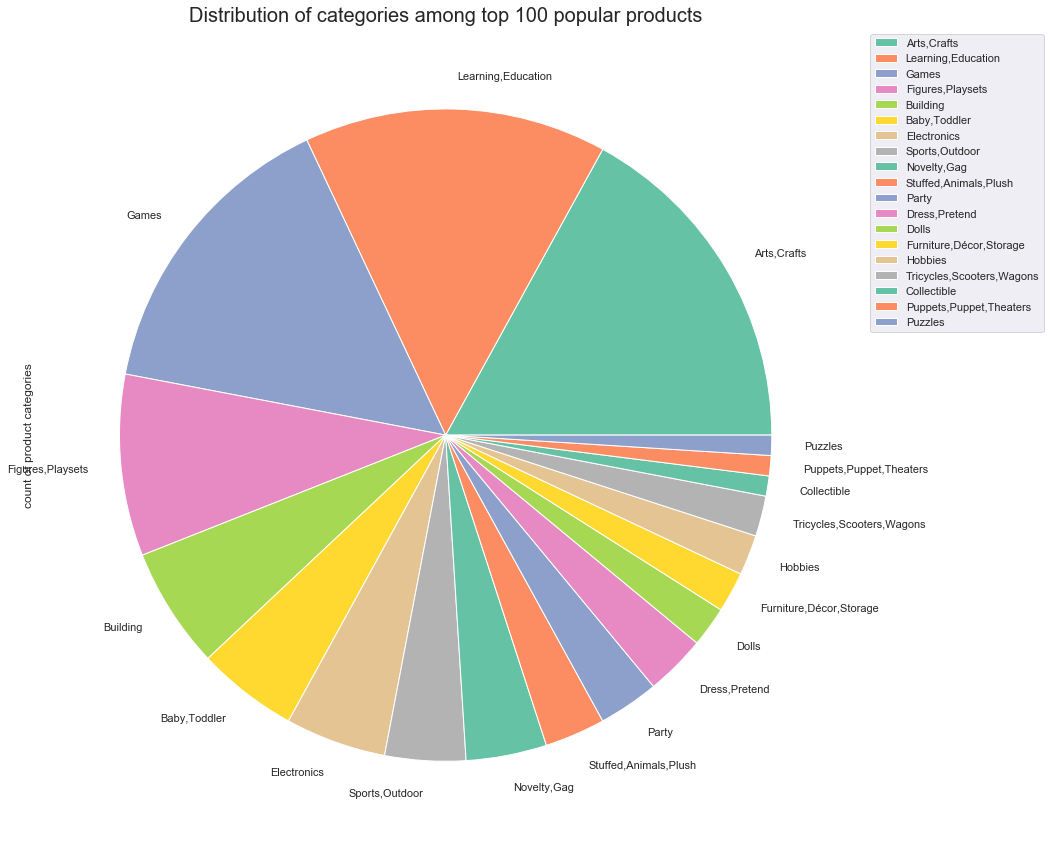

In [95]:
cmap = plt.get_cmap('Set2')
top100product_by_categories.plot.pie(y='count of product categories', figsize=(15, 15), colors=[cmap(i) for i in np.linspace(0, 1, 8)])
n = 0.62
plt.legend(loc='lower right', bbox_to_anchor=(n, n, n, n))
plt.title('Distribution of categories among top 100 popular products',fontsize=20)
plt.show()

#### Count popularity of categories amongst all products

Overall competition of categories:

In [96]:
competition = pd.DataFrame(data['category'].value_counts())
competition

,category
Others,1096860
"Arts,Crafts",386135
Electronics,337585
"Figures,Playsets",304668
Games,301732
"Learning,Education",259999
"Baby,Toddler",255061
"Novelty,Gag",250693
Party,246925
"Sports,Outdoor",207380


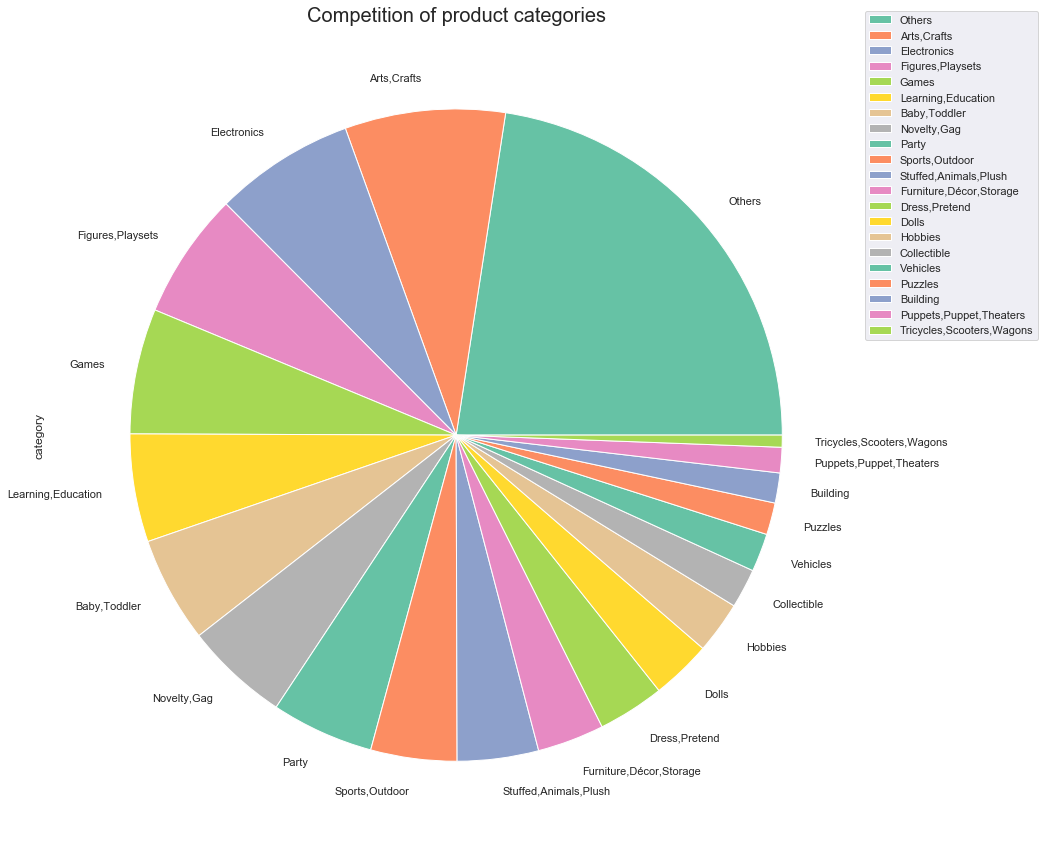

In [97]:
cmap = plt.get_cmap('Set2')
pd.DataFrame(competition).plot.pie(y='category', figsize=(15, 15), colors=[cmap(i) for i in np.linspace(0, 1, 8)])
n = 0.61
plt.legend(loc='lower right', bbox_to_anchor=(n, n, n, n))
plt.title('Competition of product categories',fontsize=20)
plt.show()

#### Count number of types of reviews by category
Looking at mean and median ratings by category: descripe popular opinion, people love leaving positive reviews

In [98]:
# median by category
review_data.groupby('category')['star_rating'].median()

category
Arts,Crafts                  5.0
Baby,Toddler                 5.0
Building                     5.0
Collectible                  5.0
Dolls                        5.0
Dress,Pretend                5.0
Electronics                  5.0
Figures,Playsets             5.0
Furniture,Décor,Storage      5.0
Games                        5.0
Hobbies                      5.0
Learning,Education           5.0
Novelty,Gag                  5.0
Party                        5.0
Puppets,Puppet,Theaters      5.0
Puzzles                      5.0
Sports,Outdoor               5.0
Stuffed,Animals,Plush        5.0
Tricycles,Scooters,Wagons    5.0
Vehicles                     5.0
Name: star_rating, dtype: float64

In [99]:
# mean by category
review_data.groupby('category')['star_rating'].mean()

category
Arts,Crafts                  4.307876
Baby,Toddler                 4.349216
Building                     4.400792
Collectible                  4.285853
Dolls                        4.501880
Dress,Pretend                4.065652
Electronics                  4.127136
Figures,Playsets             4.361851
Furniture,Décor,Storage      4.257136
Games                        4.335458
Hobbies                      4.248190
Learning,Education           4.253467
Novelty,Gag                  4.096248
Party                        4.121510
Puppets,Puppet,Theaters      4.326990
Puzzles                      4.261800
Sports,Outdoor               4.106935
Stuffed,Animals,Plush        4.455999
Tricycles,Scooters,Wagons    4.290255
Vehicles                     4.336755
Name: star_rating, dtype: float64

In [100]:
# Have a look at number of positive and negative reviews by category
review_data.groupby(['category','star_rating'])['category'].value_counts()

category                   star_rating  category                 
Arts,Crafts                1.0          Arts,Crafts                   20217
                           2.0          Arts,Crafts                   14219
                           3.0          Arts,Crafts                   25651
                           4.0          Arts,Crafts                   51299
                           5.0          Arts,Crafts                  215327
Baby,Toddler               1.0          Baby,Toddler                  12334
                           2.0          Baby,Toddler                   8133
                           3.0          Baby,Toddler                  14777
                           4.0          Baby,Toddler                  30779
                           5.0          Baby,Toddler                 139987
Building                   1.0          Building                       3122
                           2.0          Building                       2185
                      

In [101]:
# Calculating distribution of reviews per category
review_data.groupby(['category','star_rating']).size()/data.groupby(['category']).size()*100

category                   star_rating
Arts,Crafts                1.0             5.235734
                           2.0             3.682391
                           3.0             6.643013
                           4.0            13.285250
                           5.0            55.764694
Baby,Toddler               1.0             4.835706
                           2.0             3.188649
                           3.0             5.793516
                           4.0            12.067309
                           5.0            54.883734
Building                   1.0             4.319613
                           2.0             3.023175
                           3.0             5.632653
                           4.0            11.988931
                           5.0            57.815289
Collectible                1.0             5.512118
                           2.0             3.719414
                           3.0             6.737151
                         

#### Visualizing distribution of negative and positive reviews by category:

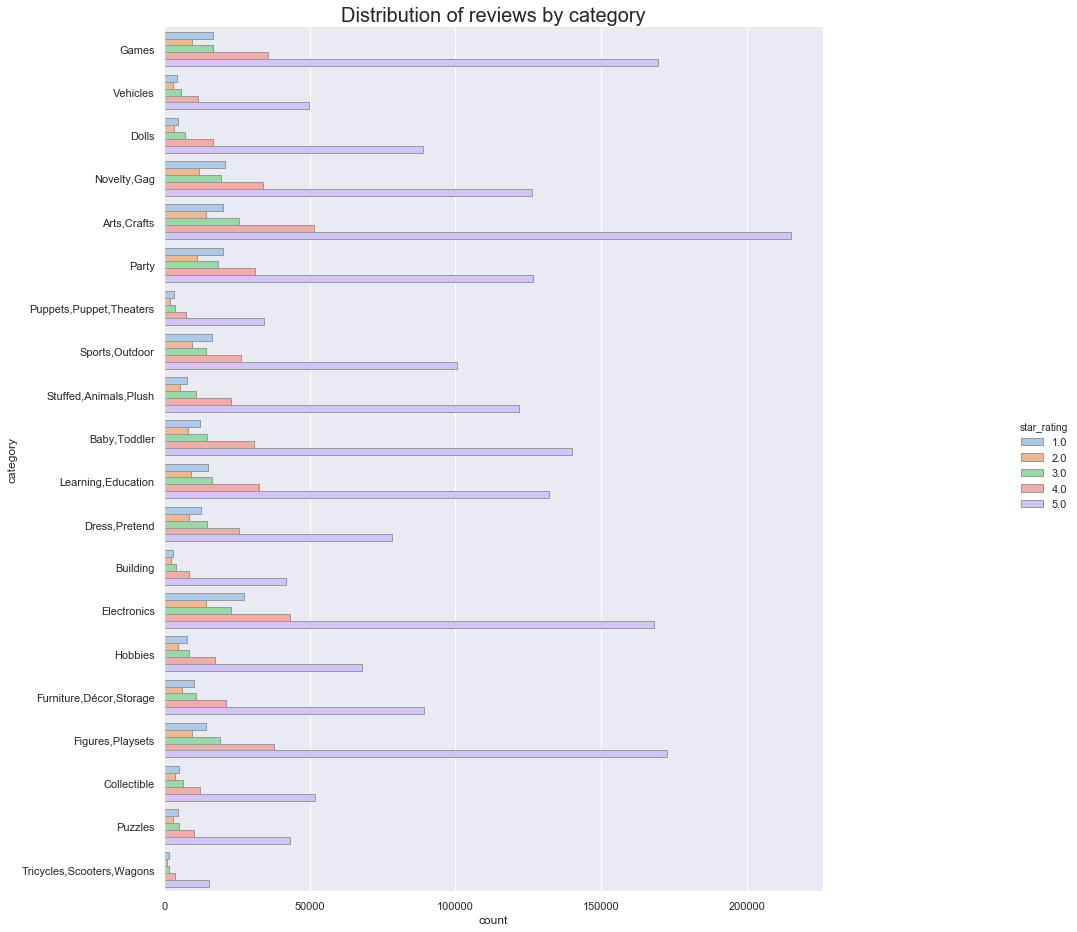

In [102]:
sns.catplot(y="category", hue="star_rating", kind="count",
            palette="pastel", edgecolor=".6",
            data=review_data);
plt.gcf().set_size_inches(24, 14)
plt.title('Distribution of reviews by category',fontsize=20)
plt.show()

In [103]:
# make clean df from results
g = pd.DataFrame(review_data.groupby(['category','star_rating']).size()/review_data.groupby(['category']).size()*100)
g.reset_index(inplace=True)
g.rename(columns={0: "rating_proportion"}, inplace=True)

#### Categories with the worst ratings:

In [104]:
include_reviews_ratings = 2
g.loc[g['star_rating']<=include_reviews_ratings]
negative_ratings_count=pd.pivot_table(g.loc[g['star_rating']<=include_reviews_ratings], 
               index=['category'],
               values='rating_proportion', 
               #columns=['star_rating'], 
               aggfunc={'rating_proportion': [np.sum]},
               fill_value=None,
               margins=False).sort_values('sum')
negative_ratings_count.reset_index(inplace=True)
negative_ratings_count.rename(columns={'sum': 'count of negative_ratings (1 and 2) proportion'}, inplace=True)
negative_ratings_count.sort_values('count of negative_ratings (1 and 2) proportion', ascending=False, inplace=True)
negative_ratings_count

,category,count of negative_ratings (1 and 2) proportion
19,"Sports,Outdoor",15.479093
18,"Novelty,Gag",15.425522
17,Party,15.148070
16,Electronics,15.051709
15,"Dress,Pretend",14.961487
14,Puzzles,12.017284
13,"Furniture,Décor,Storage",11.881843
12,"Learning,Education",11.804603
11,Hobbies,11.804132
10,Collectible,11.039190


### Visuals for categories with worst ratings:

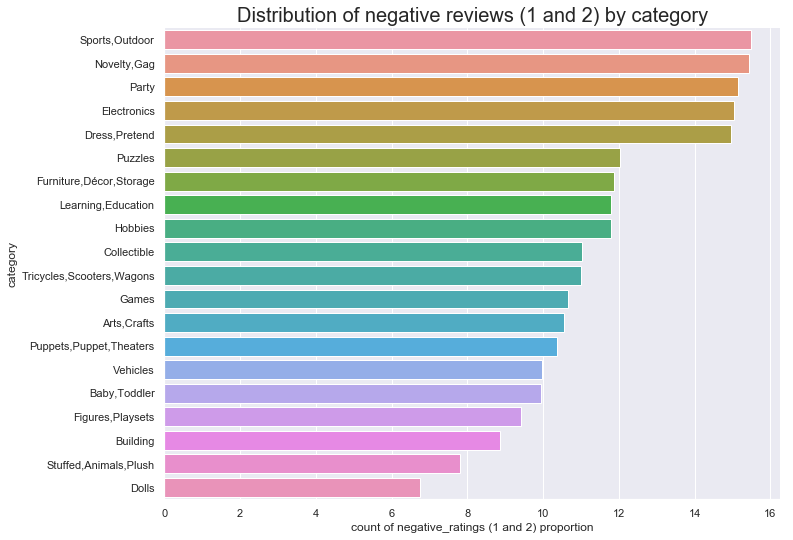

In [105]:
sns.catplot(x='count of negative_ratings (1 and 2) proportion', y='category', kind='bar', data=negative_ratings_count)
plt.gcf().set_size_inches(18, 8)
plt.title('Distribution of negative reviews (1 and 2) by category',fontsize=20)
plt.show()

#### Categories of products that get the best ratings:

In [106]:
include_reviews_ratings = 4
g.loc[g['star_rating']>=include_reviews_ratings]
positive_ratings_count=pd.pivot_table(g.loc[g['star_rating']>=include_reviews_ratings], 
               index=['category'],
               values='rating_proportion', 
               #columns=['star_rating'], 
               aggfunc={'rating_proportion': [np.sum]},
               fill_value=None,
               margins=False).sort_values('sum')
positive_ratings_count.reset_index(inplace=True)
positive_ratings_count.rename(columns={'sum': 'count of positive_ratings (4 and 5) proportion'}, inplace=True)
positive_ratings_count.sort_values('count of positive_ratings (4 and 5) proportion', ascending=False, inplace=True)
positive_ratings_count

,category,count of positive_ratings (4 and 5) proportion
19,Dolls,87.367671
18,"Stuffed,Animals,Plush",85.820277
17,Building,84.325327
16,"Figures,Playsets",83.074997
15,"Baby,Toddler",82.892093
14,Games,82.667983
13,Vehicles,82.430414
12,"Puppets,Puppet,Theaters",82.125604
11,"Arts,Crafts",81.608629
10,"Tricycles,Scooters,Wagons",81.340426


#### Visuals for categories with best ratings:

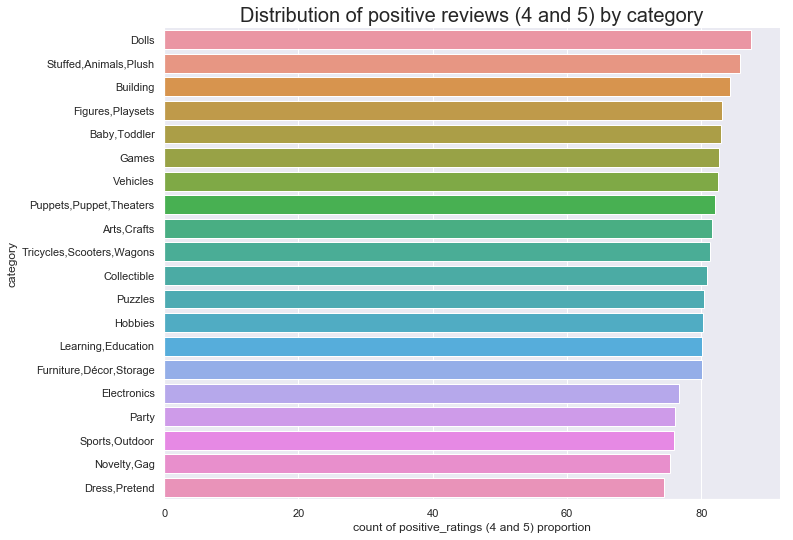

In [107]:
sns.catplot(x='count of positive_ratings (4 and 5) proportion', y='category', kind='bar', data=positive_ratings_count)
plt.gcf().set_size_inches(18, 8)
plt.title('Distribution of positive reviews (4 and 5) by category',fontsize=20)
plt.show()

#### One way to compare results would be adding a favourablity score:
- Counting proportions of competition, negative ratings and positive reviews and giving each category points
- Then merging all and adding all scores into final score
- Applying sorting

In [108]:
# adding favorability column
competition['favorability'] = (competition['category'] / competition['category'].sum() * 100)*(-1)
negative_ratings_count['favorability'] = (negative_ratings_count['count of negative_ratings (1 and 2) proportion'] / \
negative_ratings_count['count of negative_ratings (1 and 2) proportion'].sum() * 100)*(-1)
positive_ratings_count['favorability'] = positive_ratings_count['count of positive_ratings (4 and 5) proportion'] / \
positive_ratings_count['count of positive_ratings (4 and 5) proportion'].sum() * 100

In [109]:
competition.rename(columns={'category': 'category_count'}, inplace=True)
competition['category'] = competition.index

In [110]:
comparison = pd.merge(negative_ratings_count,positive_ratings_count,on='category')
comparison = pd.merge(comparison,competition,on='category')

In [111]:
comparison['score'] = comparison['favorability_x']+comparison['favorability_y']+comparison['favorability']
comparison = comparison[['category','score']]
comparison.sort_values('score', ascending=False, inplace=True)

In [112]:
comparison

,category,score
17,Building,-0.119967
10,"Tricycles,Scooters,Wagons",-0.343768
19,Dolls,-0.495916
13,"Puppets,Puppet,Theaters",-0.684797
14,Vehicles,-1.116749
9,Collectible,-1.738167
5,Puzzles,-1.827903
18,"Stuffed,Animals,Plush",-2.102423
8,Hobbies,-2.740158
6,"Furniture,Décor,Storage",-3.513438


#### Conclusions for kinds of toys that have higher odds of being popular

4 categories of products hold over 50% among top 100 popular toys, being:
- Arts and Crafts,
- Board Games,
- Learning and Education,
- Figures and Playsets

7 categories of products hold over 50% of most competitive products:
- Arts,Crafts
- Electronics
- Figures,Playsets
- Games
- Learning,Education
- Baby,Toddler
- Novelty,Gag

Lowest competition is in the following 4 categories:
- Tricycles,Scooters,Wagons
- Puppets,Puppet,Theaters
- Building
- Puzzles

High risk product categories that are likely to be unappreciated by customers:
- Sports,Outdoor
- Party
- Electronics
- Novelty,Gag

Low risk product categories that most rarely get negative reviews:
- Dolls
- Stuffed,Animals,Plush
- Building
- Figures,Playsets

Most favorable product categories getting a lot of positive reviews:
- Dolls
- Stuffed,Animals,Plush
- Building
- Games

Least favorable product categories:
- Electronics
- Novelty,Gag
- Party
- Sports,Outdoor
- Dress,Pretend

**Bottom line**

Based on score calculation method, the following are top 5 categories to consider for a low-competition, review-favourable startup toy product:
- Building
- Tricycles,Scooters,Wagons
- Puppets,Puppet,Theaters
- Dolls
- Vehicles

#### What kind of a low-investment toy / medium-investment toy / high-investment toy with previously unknown brand has higher odds of winning the users?

In [113]:
comparison_extended = pd.merge(comparison,df_investment.rename(columns={'Type':'category'}), on='category')
comparison_extended = comparison_extended[['category','score','associated_expenses']]

### Demand as an influence factor

In [114]:
top1000product_by_categories = pd.DataFrame(df.drop_duplicates('product_title').sort_values(by='title_count', \
ascending=False)[['product_title','title_count','category']].head(1000)['category'].value_counts())
top1000product_by_categories.reset_index(inplace=True)
#top1000product_by_categories.index=top100product_by_categories['index']
top1000product_by_categories.rename(columns={'index': 'category', 'category':'count of product categories'}, inplace=True)
top1000product_by_categories

,category,count of product categories
0,"Arts,Crafts",158
1,"Learning,Education",104
2,Electronics,97
3,Games,91
4,"Baby,Toddler",66
5,"Sports,Outdoor",66
6,"Novelty,Gag",65
7,"Figures,Playsets",52
8,Party,45
9,"Dress,Pretend",40


In [115]:
top1000product_by_categories['favorability'] = (top1000product_by_categories['count of product categories'] / \
                                                top1000product_by_categories['count of product categories'].sum() * 100)
top1000product_by_categories

,category,count of product categories,favorability
0,"Arts,Crafts",158,15.8
1,"Learning,Education",104,10.4
2,Electronics,97,9.7
3,Games,91,9.1
4,"Baby,Toddler",66,6.6
5,"Sports,Outdoor",66,6.6
6,"Novelty,Gag",65,6.5
7,"Figures,Playsets",52,5.2
8,Party,45,4.5
9,"Dress,Pretend",40,4.0


In [116]:
comparison_extended_long = pd.merge(comparison_extended,top1000product_by_categories, on='category')
comparison_extended_long

,category,score,associated_expenses,count of product categories,favorability
0,Building,-0.119967,medium,18,1.8
1,"Tricycles,Scooters,Wagons",-0.343768,high,8,0.8
2,Dolls,-0.495916,low,34,3.4
3,"Puppets,Puppet,Theaters",-0.684797,low,11,1.1
4,Vehicles,-1.116749,high,17,1.7
5,Collectible,-1.738167,high,20,2.0
6,Puzzles,-1.827903,low,16,1.6
7,"Stuffed,Animals,Plush",-2.102423,low,39,3.9
8,Hobbies,-2.740158,high,17,1.7
9,"Furniture,Décor,Storage",-3.513438,high,36,3.6


In [117]:
comparison_extended_long['final_score'] = comparison_extended_long['score']+comparison_extended_long['favorability']
comparison_extended_long = comparison_extended_long[['category','final_score']]

### Counting Demand In

In [118]:
comparison_extended_long.sort_values('final_score', ascending=False, inplace=True)
comparison_extended_long

,category,final_score
18,"Arts,Crafts",8.326920
13,"Learning,Education",4.882268
14,Games,3.382232
2,Dolls,2.904084
10,"Baby,Toddler",2.166859
7,"Stuffed,Animals,Plush",1.797577
0,Building,1.680033
19,Electronics,0.958177
4,Vehicles,0.583251
1,"Tricycles,Scooters,Wagons",0.456232


In [119]:
comparison_extended_long = pd.merge(comparison_extended_long,df_investment.rename(columns={'Type':'category'}), on='category')

In [120]:
comparison_extended_long = comparison_extended_long[['category','final_score','associated_expenses']]
comparison_extended_long

,category,final_score,associated_expenses
0,"Arts,Crafts",8.326920,low
1,"Learning,Education",4.882268,high
2,Games,3.382232,low
3,Dolls,2.904084,low
4,"Baby,Toddler",2.166859,high
5,"Stuffed,Animals,Plush",1.797577,low
6,Building,1.680033,medium
7,Electronics,0.958177,medium
8,Vehicles,0.583251,high
9,"Tricycles,Scooters,Wagons",0.456232,high


#### Toy categories for low, medium and high investment in descending order:

Low investment:

In [122]:
comparison_extended_long.loc[comparison_extended_long['associated_expenses']=='low'].sort_values('final_score',ascending=False)

,category,final_score,associated_expenses
2,Games,3.382232,low
3,Dolls,2.904084,low
6,Building,1.680033,medium
7,Electronics,0.958177,medium
11,"Sports,Outdoor",0.305455,high
12,Collectible,0.261833,high
14,"Figures,Playsets",-0.019751,low
16,"Novelty,Gag",-0.695574,medium
18,"Dress,Pretend",-1.194111,low


Medium investment:

In [123]:
comparison_extended_long.loc[comparison_extended_long['associated_expenses']=='medium'].sort_values('final_score',ascending=False)

,category,final_score,associated_expenses
6,Building,1.680033,medium
7,Electronics,0.958177,medium
16,"Novelty,Gag",-0.695574,medium


High investment:

In [124]:
comparison_extended_long.loc[comparison_extended_long['associated_expenses']=='high'].sort_values('final_score',ascending=False)

,category,final_score,associated_expenses
1,"Learning,Education",4.882268,high
4,"Baby,Toddler",2.166859,high
8,Vehicles,0.583251,high
9,"Tricycles,Scooters,Wagons",0.456232,high
11,"Sports,Outdoor",0.305455,high
12,Collectible,0.261833,high
13,"Furniture,Décor,Storage",0.086562,high
17,Hobbies,-1.040158,high


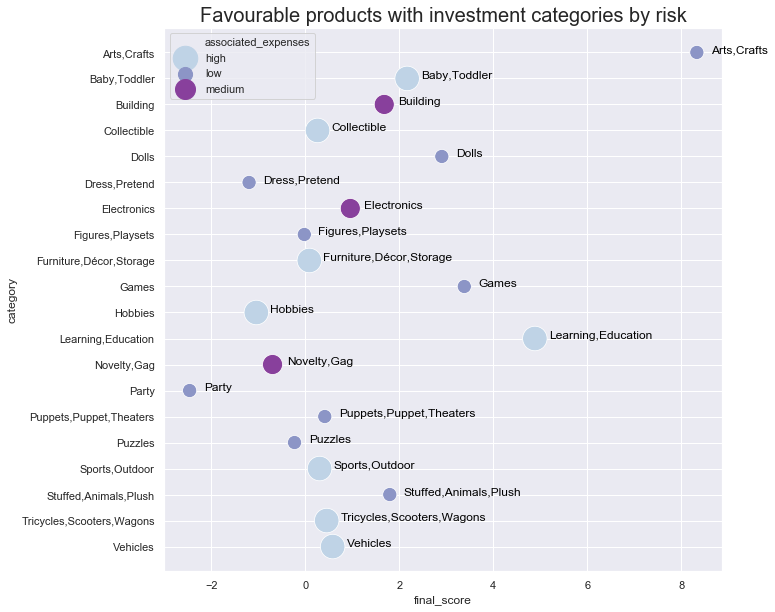

In [125]:
#cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x="final_score", y="category", 
                hue='associated_expenses',
                size='associated_expenses',
                sizes = (200, 600),
                size_order=['high', 'medium', 'low'],
                palette = sns.color_palette("BuPu", 3),
                data=comparison_extended_long.sort_values('category', ascending=False),
                #s = 600,
                alpha=1,
                legend='brief')
plt.gcf().set_size_inches(10, 10)
plt.title('Favourable products with investment categories by risk',fontsize=20)

for p in range(0,comparison_extended_long.shape[0]):
    plt.text(
        
             #x
             list(comparison_extended_long.sort_values('category', ascending=True)['final_score'])[p]+0.3,

             # y
             comparison_extended_long.shape[0]-1-p, 
            
             # annotations
             list(comparison_extended_long.sort_values('category', ascending=True)['category'])[p],

             horizontalalignment='left', 
             size='medium', 
             color='black', 
             weight='light')

### 6. Feature of products that need attention

In [126]:
df_investment_a_e=df_investment[['Type','associated_expenses']]
df_investment_a_e=df_investment_a_e.set_index(['Type'])
df_investment_a_e

,associated_expenses
Type,
"Arts,Crafts",low
"Baby,Toddler",high
Building,medium
Collectible,high
Dolls,low
"Dress,Pretend",low
Games,low
Hobbies,high
Electronics,medium


In [127]:
#total items per category
total_cat=review_data.groupby('category').counter.sum().sort_values(ascending = False)#.head(10)
total_star_cat=pd.DataFrame(data=total_cat)
total_star_cat.head()

,counter
category,
"Arts,Crafts",326713.0
Electronics,275776.0
"Figures,Playsets",253223.0
Games,248240.0
"Novelty,Gag",212492.0


In [128]:
#No. of times a category recieved more than a 4 star review
star_45= review_data[review_data['star_rating']>=4.0]
top_cat=star_45.groupby('category').counter.sum().sort_values(ascending = False)#.head(10)
star_45_top_cat=pd.DataFrame(data=top_cat)
star_45_top_cat.rename(columns={'counter': '4_or_more_stars_recieved'}, inplace=True)
star_45_top_cat.head()

,4_or_more_stars_recieved
category,
"Arts,Crafts",266626.0
Electronics,211452.0
"Figures,Playsets",210365.0
Games,205215.0
"Baby,Toddler",170766.0


In [129]:
#No. of times a category recieved less = a 2 star review
star_21= review_data[review_data['star_rating']<=2.0]
low_cat=star_21.groupby('category').counter.sum().sort_values(ascending = False)#.head(10)
star_21_low_cat=pd.DataFrame(data=low_cat)
star_21_low_cat.rename(columns={'counter': '2_or_less_stars_recieved'}, inplace=True)
star_21_low_cat.head()

,2_or_less_stars_recieved
category,
Electronics,41509.0
"Arts,Crafts",34436.0
"Novelty,Gag",32778.0
Party,31443.0
Games,26434.0


In [130]:
#merging average rating percentage and associated expenses dataframe
merge=pd.concat([total_star_cat, star_45_top_cat, star_21_low_cat],axis=1)
merge['success_percentage']= merge['4_or_more_stars_recieved']/merge['counter']*100
merge['fail_percentage']= merge['2_or_less_stars_recieved']/merge['counter']*100
merge.index.names = ['Category']
df_investment_a_e.index.names = ['Category']
merge_all=pd.concat([merge,df_investment_a_e],axis=1)

merge_all.head()

,counter,4_or_more_stars_recieved,2_or_less_stars_recieved,success_percentage,fail_percentage,associated_expenses
"Arts,Crafts",326713.0,266626.0,34436.0,81.608629,10.540138,low
"Baby,Toddler",206010.0,170766.0,20467.0,82.892093,9.934955,high
Building,59829.0,50451.0,5307.0,84.325327,8.870280,medium
Collectible,79254.0,64120.0,8749.0,80.904434,11.039190,high
Dolls,120722.0,105472.0,8150.0,87.367671,6.751048,low


In [131]:
#Top categories with highest percentage of 4 or more star ratings and associated expenses
cat_win =pd.DataFrame(data=merge_all.success_percentage.sort_values(ascending=False))
cat_win=pd.concat([cat_win,df_investment_a_e],axis=1)
cat_win=cat_win.sort_values(by ='success_percentage', ascending=False)
cat_win.head()

,success_percentage,associated_expenses
Dolls,87.367671,low
"Stuffed,Animals,Plush",85.820277,low
Building,84.325327,medium
"Figures,Playsets",83.074997,low
"Baby,Toddler",82.892093,high


In [132]:
#Top products for rank 1 category of highest percentage of 5 star ratings (Low)
DOL= review_data[(review_data['category']=="Dolls") & (review_data['star_rating']>=4.0)] 
Top_DOL_titles=DOL.groupby('product_title').counter.sum().sort_values(ascending = False).head(10)
Top_DOL_titles=pd.DataFrame(data=Top_DOL_titles)
Top_DOL_titles.rename(columns={'counter': 'No._of_4_or_more_stars_recieved'}, inplace=True)
Top_DOL_titles.head()

,No._of_4_or_more_stars_recieved
product_title,
Disney Frozen Sparkle Anna of Arendelle Doll,1027.0
Disney Frozen Snow Glow Elsa Singing Doll (Discontinued by manufacturer),1001.0
KidKraft Majestic Mansion Dollhouse,682.0
LEGO Friends Olivia's House 3315 (Discontinued by manufacturer),597.0
Barbie Dream House (Discontinued by manufacturer),488.0


In [133]:
#Top products for rank 2 category of highest percentage of 5 star ratings (Low)
SAP= review_data[(review_data['category']=="Stuffed,Animals,Plush") & (review_data['star_rating']>=4.0)] 
Top_SAP_titles=SAP.groupby('product_title').counter.sum().sort_values(ascending = False).head(10)
Top_SAP_titles=pd.DataFrame(data=Top_SAP_titles)
Top_SAP_titles.rename(columns={'counter': 'No._of_4_or_more_stars_recieved'}, inplace=True)
Top_SAP_titles.head()

,No._of_4_or_more_stars_recieved
product_title,
"Minecraft 7"" Plush Toys",1683.0
niceEshop(TM) Cute Velvet Animal Style Finger Puppets Set (Set of 10),837.0
Sesame Street Plush,732.0
"Wild Republic CK-Mini Wolf 8"" Animal Plush",659.0
Fisher-Price Little People Animal Sounds Farm,600.0


In [134]:
#Top products for rank 3 category of highest percentage of 5 star ratings (Low)
FP= review_data[(review_data['category']=="Figures,Playsets") & (review_data['star_rating']>=4.0)] 
Top_FP_titles=FP.groupby('product_title').counter.sum().sort_values(ascending = False).head(10)
Top_FP_titles=pd.DataFrame(data=Top_FP_titles)
Top_FP_titles.rename(columns={'counter': 'No._of_4_or_more_stars_recieved'}, inplace=True)
Top_FP_titles.head()

,No._of_4_or_more_stars_recieved
product_title,
Little Tikes EasyScore Basketball Set,1538.0
Minecraft Action Figures with Accessory,1361.0
Schylling Junior Helper Broom Set,1212.0
Little Tikes TotSports T-Ball Set,1054.0
Playskool Heroes Transformers Rescue Bots Energize Heatwave the Fire-Bot Figure,889.0


In [135]:
#Top products for rank 3 category of highest percentage of 5 star ratings (Medium)
Buil= review_data[(review_data['category']=="Building") & (review_data['star_rating']>=4.0)] 
Top_Buil_titles=Buil.groupby('product_title').counter.sum().sort_values(ascending = False).head(10)
Top_Buil_titles=pd.DataFrame(data=Top_Buil_titles)
Top_Buil_titles.rename(columns={'counter': 'No._of_4_or_more_stars_recieved'}, inplace=True)
Top_Buil_titles.head()

,No._of_4_or_more_stars_recieved
product_title,
Mega Bloks 80-Piece Big Building Bag,2104.0
Fisher-Price Blocks,1319.0
"LEGO 626 Green Building Plate (10"" x 10"") (Discontinued by manufacturer)",977.0
LEGO Ultimate Building Set - 405 Pieces (6166) (Discontinued by manufacturer),952.0
LEGO The DeLorean Time Machine Building Set 21103 (Discontinued by manufacturer),807.0


In [136]:
#Top products for rank 3 category of highest percentage of 5 star ratings (Medium)
Elec= review_data[(review_data['category']=="Electronics") & (review_data['star_rating']>=4.0)] 
Top_Elec_titles=Elec.groupby('product_title').counter.sum().sort_values(ascending = False).head(10)
Top_Elec_titles=pd.DataFrame(data=Top_Elec_titles)
Top_Elec_titles.rename(columns={'counter': 'No._of_4_or_more_stars_recieved'}, inplace=True)
Top_Elec_titles.head()

,No._of_4_or_more_stars_recieved
product_title,
UDI U818A 2.4GHz 4 CH 6 Axis Gyro RC Quadcopter with Camera RTF Mode 2,1576.0
Syma X5C Explorers 2.4G 4CH 6-Axis Gyro RC Quadcopter With HD Camera,1076.0
InnoTab 3 Plus The Learning Tablet,862.0
Radio Flyer 4-in-1 Stroll 'N Trike,724.0
Step 2 Up & Down Roller Coaster,633.0


In [137]:
#Top products for rank 3 category of highest percentage of 5 star ratings (High)
BT= review_data[(review_data['category']=="Baby,Toddler") & (review_data['star_rating']>=4.0)] 
Top_BT_titles=BT.groupby('product_title').counter.sum().sort_values(ascending = False).head(10)
Top_BT_titles=pd.DataFrame(data=Top_BT_titles)
Top_BT_titles.rename(columns={'counter': 'No._of_4_or_more_stars_recieved'}, inplace=True)
Top_BT_titles.head()

,No._of_4_or_more_stars_recieved
product_title,
Accoutrements Horse Head Mask,1913.0
Ticket To Ride,1823.0
Manhattan Toy Winkel Rattle and Sensory Teether Activity Toy,1174.0
Swimways Baby Spring,733.0
Manhattan Toy Baby Stella Doll,727.0


In [138]:
#Top products for rank 3 category of highest percentage of 5 star ratings (High)
PW= review_data[(review_data['category']=="Play Vehicles") & (review_data['star_rating']>=4.0)] 
Top_PW_titles=PW.groupby('product_title').counter.sum().sort_values(ascending = False).head(10)
Top_PW_titles=pd.DataFrame(data=Top_PW_titles)
Top_PW_titles.rename(columns={'counter': 'No._of_4_or_more_stars_recieved'}, inplace=True)
Top_PW_titles.head()

,No._of_4_or_more_stars_recieved
product_title,


In [139]:
#LOW RATINGS!

In [140]:
#Categories with highest percentage of 2 or less star reviews and their associated expenses
cat_fail=pd.DataFrame(data=merge_all.fail_percentage.sort_values(ascending=False))
cat_fail=pd.concat([cat_fail,df_investment_a_e],axis=1)
cat_fail=cat_fail.sort_values(by ='fail_percentage', ascending=False)
cat_fail.head()

,fail_percentage,associated_expenses
"Sports,Outdoor",15.479093,high
"Novelty,Gag",15.425522,medium
Party,15.148070,low
Electronics,15.051709,medium
"Dress,Pretend",14.961487,low


In [141]:
#Worst rated products for rank 1 category of highest percentage 2 or less star ratings (High)
SO= review_data[(review_data['category']=="Sports,Outdoor") & (review_data['star_rating']<=2.0)] 
Worst_SO_titles=SO.groupby('product_title').counter.sum().sort_values(ascending = False).head(10)
Worst_SO_titles=pd.DataFrame(data=Worst_SO_titles)
Worst_SO_titles.rename(columns={'counter': 'No._of_2_or_less_stars_recieved'}, inplace=True)
Worst_SO_titles.head()

,No._of_2_or_less_stars_recieved
product_title,
Joissu Flingshot Slingshot Flying Screaming Monkey,177.0
Flutterbye Flying Fairy,167.0
"Intex Water Slide Inflatable Play Center, 135"" X 81"" X 50"", for Ages 6+",162.0
Insect Lore Live Butterfly Garden,133.0
"Intex Floating Recliner Inflatable Lounge, 71 X 53-Inch (Colors May Vary)",125.0


In [142]:
#Worst rated products for rank 1 category of highest percentage 2 or less star ratings (High)
Fur= review_data[(review_data['category']=="Furniture,Décor,Storage") & (review_data['star_rating']<=2.0)] 
Worst_Fur_titles=Fur.groupby('product_title').counter.sum().sort_values(ascending = False).head(10)
Worst_Fur_titles=pd.DataFrame(data=Worst_Fur_titles)
Worst_Fur_titles.rename(columns={'counter': 'No._of_2_or_less_stars_recieved'}, inplace=True)
Worst_Fur_titles.head()

,No._of_2_or_less_stars_recieved
product_title,
"1 Pack of Shocking Gum, Funny Shock Gag Random Color",306.0
Estes Proto X Nano R/C Quadcopter-p,211.0
"1 X Magical Colorful Loom Kit, Includes Loom, Hook, Bands, Clips & Charms",120.0
1 X Water Game - Triangles (Colors may vary - Red/Blue),74.0
"The Original 46"" Bozo 3-D Bop Bag",71.0


In [143]:
#Worst rated products for rank 1 category of highest percentage 2 or less star ratings (High)
Edu= review_data[(review_data['category']=="Learning,Education") & (review_data['star_rating']<=2.0)] 
Worst_Edu_titles=Edu.groupby('product_title').counter.sum().sort_values(ascending = False).head(10)
Worst_Edu_titles=pd.DataFrame(data=Worst_Edu_titles)
Worst_Edu_titles.rename(columns={'counter': 'No._of_2_or_less_stars_recieved'}, inplace=True)
Worst_Edu_titles.head()

,No._of_2_or_less_stars_recieved
product_title,
"Rainbow Loom Crafting Kit includes Loom, Metal Hook, Mini Rainbow Loom, 600 Rubber Bands + 24 Clips",472.0
Lowpricenice Solar Car - World's Smallest Solar Powered Car - Educational Solar Powered Toy,247.0
LeapFrog LeapPad Ultra/Ultra XDI Kids' Learning Tablet,185.0
LeapFrog LeapPad2 Explorer Kids' Learning Tablet or Bundle,159.0
Westminster Rotating Fiber Optic Light,158.0


In [144]:
#Worst rated products for rank 1 category of highest percentage 2 or less star ratings (Medium)
NG= review_data[(review_data['category']=="Novelty,Gag") & (review_data['star_rating']<=2.0)] 
Worst_NG_titles=NG.groupby('product_title').counter.sum().sort_values(ascending = False).head(10)
Worst_NG_titles=pd.DataFrame(data=Worst_NG_titles)
Worst_NG_titles.rename(columns={'counter': 'No._of_2_or_less_stars_recieved'}, inplace=True)
Worst_NG_titles.head()

,No._of_2_or_less_stars_recieved
product_title,
Money Maze Bank by Dragonpad,245.0
"Crazy Aaron's Thinking Putty, 3.2 Ounce",203.0
Rhode Island Novelty Light-Up LED Transparent Bubble Gun (Colors May Vary),181.0
1000 Magic the Gathering Cards Plus Bonus 25 Rares,176.0
Fun Central Mini Glow Sticks,160.0


In [145]:
#Worst rated products for rank 1 category of highest percentage 2 or less star ratings (Medium)
Elec= review_data[(review_data['category']=="Electronics") & (review_data['star_rating']<=2.0)] 
Worst_Elec_titles=Elec.groupby('product_title').counter.sum().sort_values(ascending = False).head(10)
Worst_Elec_titles=pd.DataFrame(data=Worst_Elec_titles)
Worst_Elec_titles.rename(columns={'counter': 'No._of_2_or_less_stars_recieved'}, inplace=True)
Worst_Elec_titles.head()

,No._of_2_or_less_stars_recieved
product_title,
UDI U818A 2.4GHz 4 CH 6 Axis Gyro RC Quadcopter with Camera RTF Mode 2,421.0
Air Swimmers Remote Control Flying Shark,303.0
InnoTab 3 Plus The Learning Tablet,233.0
Syma Big CH-47 Chinook 3 Channels RC Helicopter *Colors May Vary,230.0
Angry Birds Air Swimmers Turbo - RED Flying Remote Control Balloon Toy,172.0


In [146]:
#Worst rated products for rank 1 category of highest percentage 2 or less star ratings (Low)
PS= review_data[(review_data['category']=="Party Supplies") & (review_data['star_rating']<=2.0)] 
Worst_PS_titles=PS.groupby('product_title').counter.sum().sort_values(ascending = False).head(10)
Worst_PS_titles=pd.DataFrame(data=Worst_PS_titles)
Worst_PS_titles.rename(columns={'counter': 'No._of_2_or_less_stars_recieved'}, inplace=True)
Worst_PS_titles.head()

,No._of_2_or_less_stars_recieved
product_title,


In [147]:
#Worst rated products for rank 1 category of highest percentage 2 or less star ratings (Low)
DP= review_data[(review_data['category']=="Dress,Pretend") & (review_data['star_rating']<=2.0)] 
Worst_DP_titles=DP.groupby('product_title').counter.sum().sort_values(ascending = False).head(10)
Worst_DP_titles=pd.DataFrame(data=Worst_DP_titles)
Worst_DP_titles.rename(columns={'counter': 'No._of_2_or_less_stars_recieved'}, inplace=True)
Worst_DP_titles.head()

,No._of_2_or_less_stars_recieved
product_title,
Disney Frozen Enchanting Elsa Dress,305.0
Disguise - Frozen Elsa Wig,144.0
Leegoal(TM) Unicorn Horn Headband Flowers Ears Headband Gold Glitter Hair Hoop Girls Kids Cosplay Costume Makeup Birthday Party Headdress,101.0
"Velocity Toys Deluxe Beauty Kitchen Appliance Cooking Play Set 24"" w/ Lights & Sound",99.0
Playhut Beauty Boutique Play Tent,95.0


In [148]:
#Worst rated products for rank 1 category of highest percentage 2 or less star ratings (Low)
Puzz= review_data[(review_data['category']=="Puzzles") & (review_data['star_rating']<=2.0)] 
Worst_Puzz_titles=Puzz.groupby('product_title').counter.sum().sort_values(ascending = False).head(10)
Worst_Puzz_titles=pd.DataFrame(data=Worst_Puzz_titles)
Worst_Puzz_titles.rename(columns={'counter': 'No._of_2_or_less_stars_recieved'}, inplace=True)
Worst_Puzz_titles.head()

,No._of_2_or_less_stars_recieved
product_title,
4M Glow 3D Solar System,145.0
"WolVol Electric Fire Truck Toy With Stunning 3D Lights and Sirens, goes around and changes directions on contact - Great Gift Toys for Kids",94.0
Schylling Tea Set Basket,83.0
Shengshou Pyraminx Speedcubing Black Puzzle,82.0
"ShengShou 3x3x3 Puzzle Cube, Black",66.0


In [149]:
bad1= review_data[(review_data['product_title']=="Joissu Flingshot Slingshot Flying Screaming Monkey") & (review_data['star_rating']<=2.0)] 
bad1_split=pd.Series(' '.join(bad1['review_body']).lower().split()).value_counts()
bad1_split=pd.DataFrame(data=bad1_split)
bad1_split.index.names = ['words']
exclude1=['but','no','when','did','all','or','do','from','what','they','these','the','on','it','and','i','it.','at','to','is','a','for','this','my','was','not','very','of','that','so','as','be','in','have','it','with','we','are','you']
bad1_filter= bad1_split.drop(exclude1)
bad1_filter.rename(columns={0:'count'}, inplace=True)
bad1_filter.head()

,count
words,
monkey,52
broke,40
first,33
one,29
would,25


In [150]:
bad2= review_data[(review_data['product_title']=="1 Pack of Shocking Gum, Funny Shock Gag Random Color") & (review_data['star_rating']<=2.0)] 
bad2_split=pd.Series(' '.join(bad2['review_body']).lower().split()).value_counts()
bad2_split=pd.DataFrame(data=bad2_split)
bad2_split.index.names = ['words']
exclude2=['but','no','when','did','all','do','from','what','they','these','the','on','it','and','i','it.','at','to','is','a','for','this','my','was','not','very','of','that','so','as','be','in','have','it','with','we','are','you']
bad2_filter= bad2_split.drop(exclude2)
bad2_filter.rename(columns={0:'count'}, inplace=True)
bad2_filter.head()

,count
words,
work,71
didn't,65
get,48
even,46
got,46


In [151]:
bad3= review_data[(review_data['product_title']=="Rainbow Loom Crafting Kit includes Loom, Metal Hook, Mini Rainbow Loom, 600 Rubber Bands + 24 Clips") & (review_data['star_rating']<=2.0)] 
bad3_split=pd.Series(' '.join(bad3['review_body']).lower().split()).value_counts()
bad3_split=pd.DataFrame(data=bad3_split)
bad3_split.index.names = ['words']
exclude3=['rainbow','one','loom','loom.','but','no','when','did','all','do','from','what','they','these','the','on','it','and','i','it.','at','to','is','a','for','this','my','was','not','very','of','that','so','as','be','in','have','it','with','we','are','you']
bad3_filter= bad3_split.drop(exclude3)
bad3_filter.rename(columns={0:'count'}, inplace=True)
bad3_filter.head()

,count
words,
real,221
product,140
amazon,123
had,117
were,109


In [152]:
bad4= review_data[(review_data['product_title']=="Money Maze Bank by Dragonpad") & (review_data['star_rating']<=2.0)] 
bad4_split=pd.Series(' '.join(bad4['review_body']).lower().split()).value_counts()
bad4_split=pd.DataFrame(data=bad4_split)
bad4_split.index.names = ['words']
exclude4=['money','maze','had','would','them','were','one','but','no','when','did','all','do','from','what','they','these','the','on','it','and','i','it.','at','to','is','a','for','this','my','was','not','very','of','that','so','as','be','in','have','it','with','we','are','you']
bad4_filter= bad4_split.drop(exclude4)
bad4_filter.rename(columns={0:'count'}, inplace=True)
bad4_filter.head()

,count
words,
ball,54
broke,49
gift,45
open,43
bought,43


In [153]:

bad5= review_data[(review_data['product_title']=="UDI U818A 2.4GHz 4 CH 6 Axis Gyro RC Quadcopter with Camera RTF Mode 2") & (review_data['star_rating']<=2.0)] 
bad5_split=pd.Series(' '.join(bad5['review_body']).lower().split()).value_counts()
bad5_split=pd.DataFrame(data=bad5_split)
bad5_split.index.names = ['words']
exclude5=['money','had','after','out','get','if','even','or','just','/><br','would','them','were','one','but','no','when','did','all','do','from','what','they','these','the','on','it','and','i','it.','at','to','is','a','for','this','my','was','not','very','of','that','so','as','be','in','have','it','with','we','are','you']
bad5_filter= bad5_split.drop(exclude5)
bad5_filter.rename(columns={0:'count'}, inplace=True)
bad5_filter.head()

,count
words,
battery,159
fly,81
first,62
about,60
only,59


In [154]:
bad6= review_data[(review_data['product_title']=="Gazillion Bubble Hurricane Machine") & (review_data['star_rating']<=2.0)] 
bad6_split=pd.Series(' '.join(bad6['review_body']).lower().split()).value_counts()
bad6_split=pd.DataFrame(data=bad6_split)
bad6_split.index.names = ['words']
exclude6=['bubble','machine','bubbles','money','had','after','out','get','if','even','or','just','/><br','would','them','were','one','but','no','when','did','all','do','from','what','they','these','the','on','it','and','i','it.','at','to','is','a','for','this','my','was','not','very','of','that','so','as','be','in','have','it','with','we','are','you']
bad6_filter= bad6_split.drop(exclude6)
bad6_filter.rename(columns={0:'count'}, inplace=True)
bad6_filter.head()

,count
words,
use,48
worked,47
only,45
batteries,43
time,43


In [155]:
bad7= review_data[(review_data['product_title']=="Disney Frozen Enchanting Elsa Dress") & (review_data['star_rating']<=2.0)] 
bad7_split=pd.Series(' '.join(bad7['review_body']).lower().split()).value_counts()
bad7_split=pd.DataFrame(data=bad7_split)
bad7_split.index.names = ['words']
exclude7=['money','had','after','out','get','if','even','or','just','/><br','would','them','were','one','but','no','when','did','all','do','from','what','they','these','the','on','it','and','i','it.','at','to','is','a','for','this','my','was','not','very','of','that','so','as','be','in','have','it','with','we','are','you']
bad7_filter= bad7_split.drop(exclude7)
bad7_filter.rename(columns={0:'count'}, inplace=True)
bad7_filter.head()

,count
words,
dress,146
daughter,86
she,83
wear,73
material,61


In [156]:

bad8= review_data[(review_data['product_title']=="4M Glow 3D Solar System") & (review_data['star_rating']<=2.0)] 
bad8_split=pd.Series(' '.join(bad8['review_body']).lower().split()).value_counts()
bad8_split=pd.DataFrame(data=bad8_split)
bad8_split.index.names = ['words']
exclude8=['money','had','after','out','get','if','even','or','just','/><br','would','them','were','one','but','no','when','did','all','do','from','what','they','these','the','on','it','and','i','it.','at','to','is','a','for','this','my','was','not','very','of','that','so','as','be','in','have','it','with','we','are','you']
bad8_filter= bad8_split.drop(exclude8)
bad8_filter.rename(columns={0:'count'}, inplace=True)
bad8_filter.head()

,count
words,
stars,70
glow,67
don't,34
off,28
stick,26


### 7. Seasonality Analysis 

In [157]:
# DELETE Others from toys category
review_data2 = review_data.set_index("category")

In [158]:
review_data2.reset_index(inplace=True)

In [159]:
# toy categories without Others
review_data2['category'].value_counts(dropna = False).head(30)

Arts,Crafts                  326713
Electronics                  275776
Figures,Playsets             253223
Games                        248240
Novelty,Gag                  212492
Party                        207571
Baby,Toddler                 206010
Learning,Education           205530
Stuffed,Animals,Plush        168882
Sports,Outdoor               167316
Dress,Pretend                139692
Furniture,Décor,Storage      137546
Dolls                        120722
Hobbies                      106378
Collectible                   79254
Vehicles                      74333
Puzzles                       66421
Building                      59829
Puppets,Puppet,Theaters       50922
Tricycles,Scooters,Wagons     23500
Name: category, dtype: int64

In [160]:
# Cards Against Humanity the most popular toy according to number of reviews
review_data2['product_title'].value_counts(dropna = False).head(10)

Cards Against Humanity                                                    23124
Melissa & Doug                                                             9947
Cards Against Humanity: First Expansion                                    5851
VTech Sit-to-Stand Learning Walker                                         4374
Cards Against Humanity: Second Expansion                                   3838
The Original Stomp Rocket                                                  2681
Cards Against Humanity: Third Expansion                                    2667
Cards Against Humanity: Fourth Expansion                                   2236
UDI U818A 2.4GHz 4 CH 6 Axis Gyro RC Quadcopter with Camera RTF Mode 2     2227
Mega Bloks 80-Piece Big Building Bag                                       2199
Name: product_title, dtype: int64

In [161]:
# Adjusting data for Seasonality Analysis
# Making data’s days combined for years and/or months
#review_data['review_date'] = pd.to_datetime(review_data['review_date'],format='%Y-%m-%d', errors='coerce')

seasonality = pd.to_datetime(review_data2['review_date'],format='%Y-%m-%d', errors='coerce')

In [162]:
review_data2['review_date'] = seasonality

In [163]:
review_data2['year'] = review_data2['review_date'].dt.year
review_data2['month'] = review_data2['review_date'].dt.month

In [164]:
review_data2['year'] = review_data2['year'].fillna(0.0).astype(int)
review_data2['month'] = review_data2['month'].fillna(0.0).astype(int)

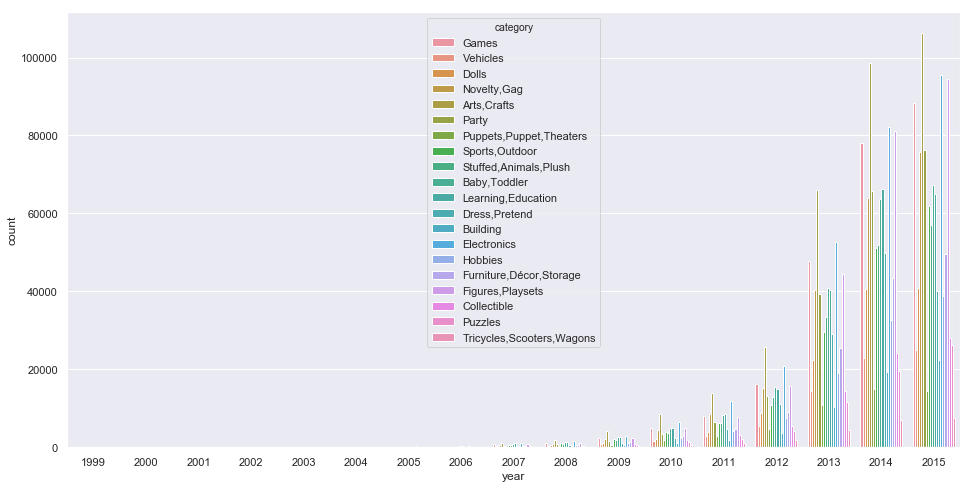

In [165]:
# YOY for all toys categories
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
sns.countplot(x="year", hue="category", data=review_data2, ax=ax)

In [166]:
# Since we already know that number of toys on Amazon was not significant from 1997 to 2009 we will combine these years
# to make graphic more visible.
bins = [ 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2020]
labels = ['1999-2009', '2010', '2011', '2012', '2013', '2014', '2015']
review_data2['Years'] = pd.cut(review_data2['year'], bins = bins, labels = labels, right = False)

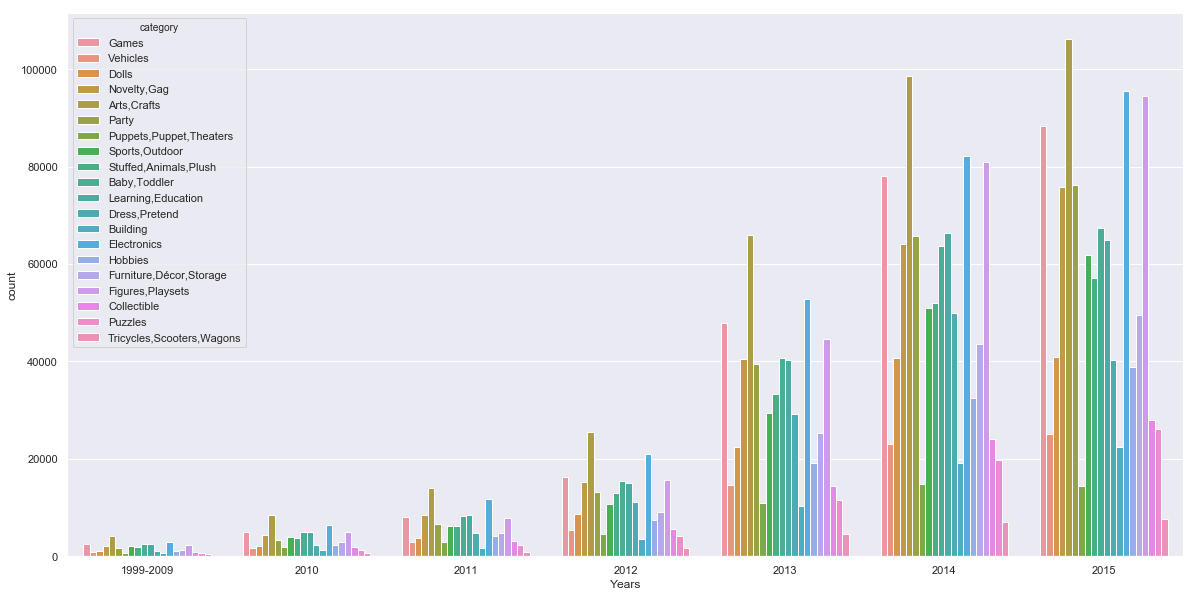

In [167]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.countplot(x="Years", hue="category", data=review_data2, ax=ax)

In [168]:
# Let's see what toy categories that been popular in 2015
year_2015 = review_data2.loc[review_data2['year'] == 2015]
year_2015 = year_2015[['category','star_rating','year']].groupby(['category']).size().reset_index().\
    rename(columns={0: 'count'})
year_2015

,category,count
0,"Arts,Crafts",106263
1,"Baby,Toddler",67417
2,Building,22427
3,Collectible,27958
4,Dolls,40813
5,"Dress,Pretend",40213
6,Electronics,95426
7,"Figures,Playsets",94413
8,"Furniture,Décor,Storage",49481
9,Games,88222


/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


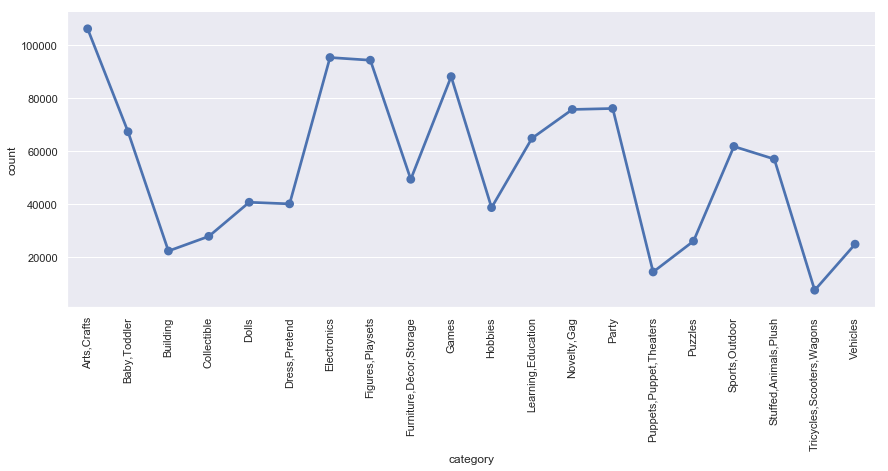

In [169]:
# Top toy categories that been popular in 2015 Games, Arts & Crafts, Electronics, Figures & Playsets
fig_year_2015 = sns.factorplot('category','count', data=year_2015, aspect = 2.5, );
fig_year_2015.set_xticklabels(rotation=90)

In [170]:
# Let's see what toy categories that been popular in 2014
year_2014 = review_data2.loc[review_data2['year'] == 2014]
year_2014 = year_2014[['category','star_rating','year']].groupby(['category']).size().reset_index().\
    rename(columns={0: 'count'})
year_2014

,category,count
0,"Arts,Crafts",98571
1,"Baby,Toddler",63667
2,Building,19228
3,Collectible,24170
4,Dolls,40610
5,"Dress,Pretend",49973
6,Electronics,82078
7,"Figures,Playsets",81032
8,"Furniture,Décor,Storage",43505
9,Games,77971


/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


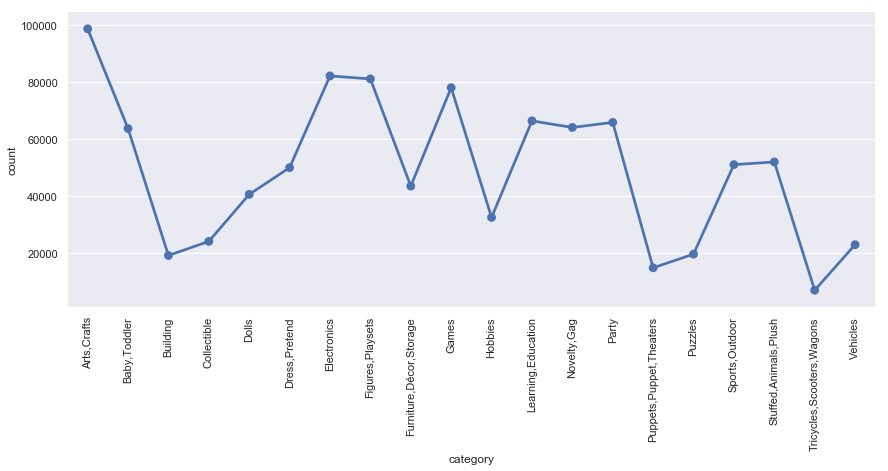

In [171]:
# Top toy categories that been popular in 2014 Games, Arts & Crafts, Electronics, Figures & Playsets
fig_year_2014 = sns.factorplot('category','count', data=year_2014, aspect = 2.5, );
fig_year_2014.set_xticklabels(rotation=90)

In [172]:
# Let's see what toy categories that been popular in 2013
year_2013 = review_data2.loc[review_data2['year'] == 2013]
year_2013 = year_2013[['category','star_rating','year']].groupby(['category']).size().reset_index().\
    rename(columns={0: 'count'})
year_2013

,category,count
0,"Arts,Crafts",65920
1,"Baby,Toddler",40797
2,Building,10413
3,Collectible,14515
4,Dolls,22396
5,"Dress,Pretend",29111
6,Electronics,52786
7,"Figures,Playsets",44525
8,"Furniture,Décor,Storage",25403
9,Games,47914


/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


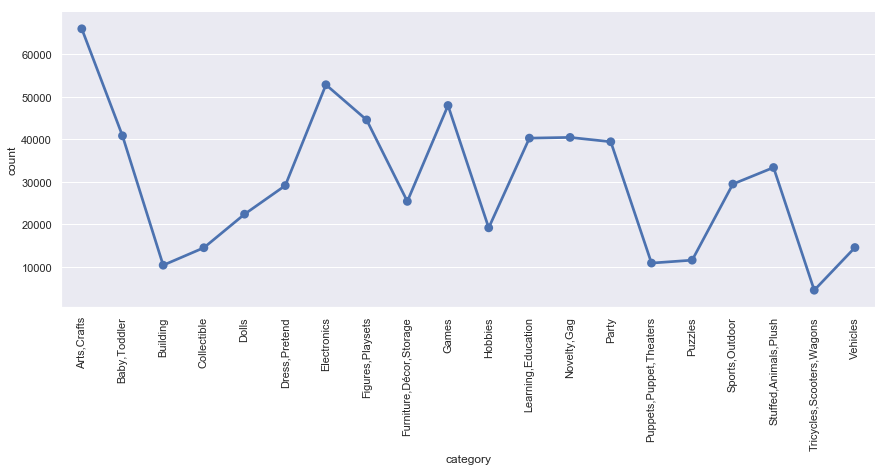

In [173]:
# Top toy categories that been popular in 2013 Arts & Crafts, Electronics, Games
fig_year_2013 = sns.factorplot('category','count', data=year_2013, aspect = 2.5, );
fig_year_2013.set_xticklabels(rotation=90)

In [174]:
# Let's see what toy categories that been popular in 2012
year_2012 = review_data2.loc[review_data2['year'] == 2012]
year_2012 = year_2012[['category','star_rating','year']].groupby(['category']).size().reset_index().\
    rename(columns={0: 'count'})
year_2012

,category,count
0,"Arts,Crafts",25606
1,"Baby,Toddler",15435
2,Building,3551
3,Collectible,5589
4,Dolls,8739
5,"Dress,Pretend",11094
6,Electronics,20955
7,"Figures,Playsets",15684
8,"Furniture,Décor,Storage",8998
9,Games,16244


/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


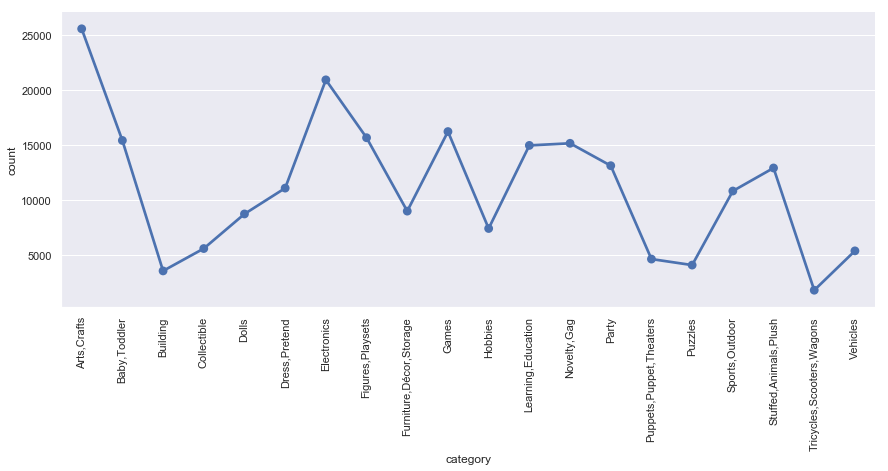

In [175]:
# Top toy categories that been popular in 2012 Arts & Crafts, Electronics
fig_year_2012 = sns.factorplot('category','count', data=year_2012, aspect = 2.5, );
fig_year_2012.set_xticklabels(rotation=90)

In [176]:
top_categories = review_data2.loc[(review_data2['category'] == 'Games') | (review_data2['category'] == 'Electronics')|(review_data2['category'] == 'Arts,Crafts')|(review_data2['category'] == 'Figures,Playsets')]

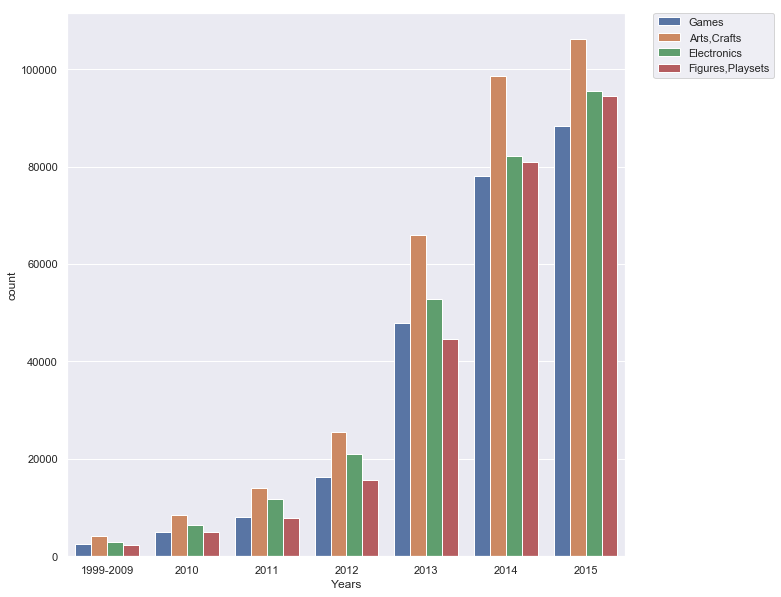

In [177]:
# Let's build plot for top categories Games, Arts & Crafts, Electronics, Figures & Playsets 
# and see results YOY
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.countplot(x="Years", hue="category", data=top_categories, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Summary we can see that the popularity of toy categories for Games, Arts & Crafts, Electronics, Figures & Playsets Significantly increased YOY. That because the number of products that sell on Amazon growing YOY, but the popularities of toy categories remains the same.

#### Let's answer for the question. What is the surge in review there is during SALE events like for example Black Friday

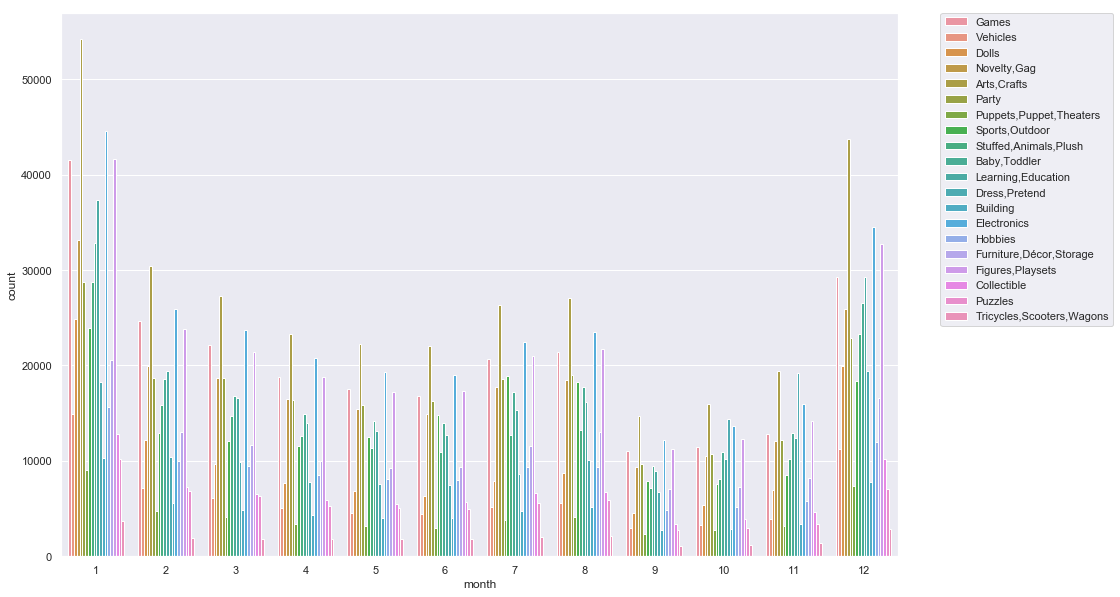

In [178]:
# MOM for all toys categories
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.countplot(x="month", hue="category", data=review_data2, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [179]:
# number of reviews by month January (1), December(12), November (11), October(10),September(9), August (8), etc.
review_data2['month'].value_counts(dropna = False).head(13)

1     506812
12    400952
2     289221
8     267621
3     262599
7     256181
4     227513
5     214547
6     213719
11    190730
10    160454
9     140001
Name: month, dtype: int64

From MOM analysis we can see that the most popular months are January (1), December(12)

In [180]:
# Let's see top toy categories that are popular during holiday months
# Black Friday  - November (11)
# Christmas December (12)
# New Year January (1)

In [181]:
# New Year January (1) 
january = review_data2.loc[review_data2['month'] == 1]
january = january[['category','star_rating','month']].groupby(['category']).size().reset_index().\
    rename(columns={0: 'count'})

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


,category,count
0,"Arts,Crafts",54249
1,"Baby,Toddler",32795
2,Building,10281
3,Collectible,12769
4,Dolls,24821
5,"Dress,Pretend",18215
6,Electronics,44539
7,"Figures,Playsets",41599
8,"Furniture,Décor,Storage",20611
9,Games,41540


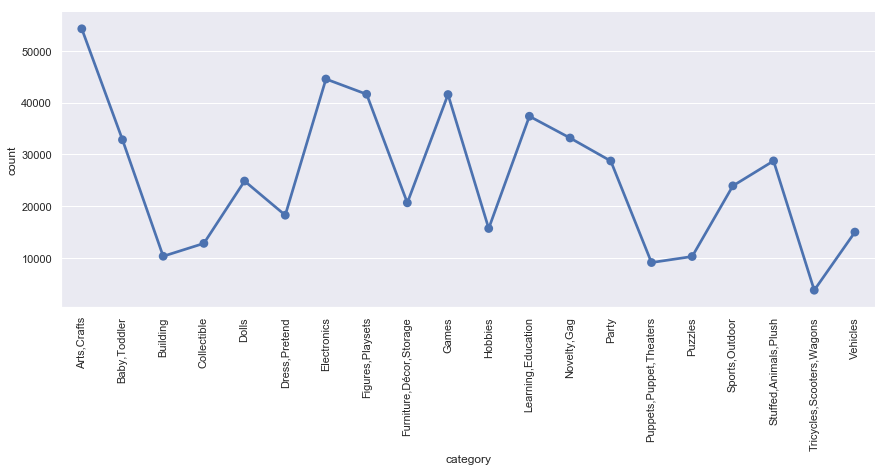

In [182]:
# Toy categories that are most popular during January (Arts & Crafts,Dolls & Accessories, Electronics for Kids )

fig_january = sns.factorplot('category','count', data=january, aspect = 2.5, );
fig_january.set_xticklabels(rotation=90)
january

In [183]:
# Christmas December (12)
december = review_data2.loc[review_data2['month'] == 12]
december = december[['category','star_rating','month']].groupby(['category']).size().reset_index().\
    rename(columns={0: 'count'})
december

,category,count
0,"Arts,Crafts",43697
1,"Baby,Toddler",26530
2,Building,7822
3,Collectible,10190
4,Dolls,19930
5,"Dress,Pretend",19379
6,Electronics,34517
7,"Figures,Playsets",32717
8,"Furniture,Décor,Storage",16578
9,Games,29307


/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


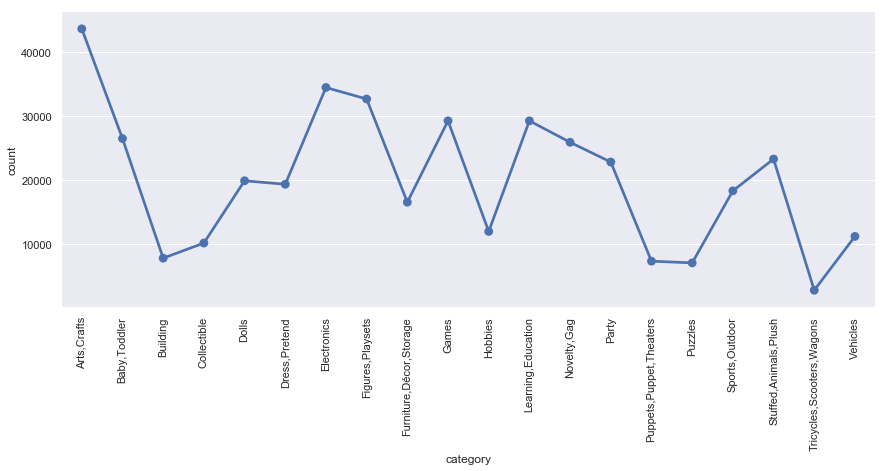

In [184]:
#Toy categories that are most popular during December (Arts & Crafts, Dolls, Electronics, Figures & Playsets, 
#Games, and Learning & Education )
fig_december = sns.factorplot('category','count', data=december, aspect = 2.5, );
fig_december.set_xticklabels(rotation=90)

In [185]:
# Black Friday  - November (11)
november = review_data2.loc[review_data2['month'] == 11]
november = november[['category','star_rating','month']].groupby(['category']).size().reset_index().\
    rename(columns={0: 'count'})
november

,category,count
0,"Arts,Crafts",19456
1,"Baby,Toddler",12893
2,Building,3399
3,Collectible,4675
4,Dolls,6921
5,"Dress,Pretend",19238
6,Electronics,15935
7,"Figures,Playsets",14134
8,"Furniture,Décor,Storage",8234
9,Games,12831


/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


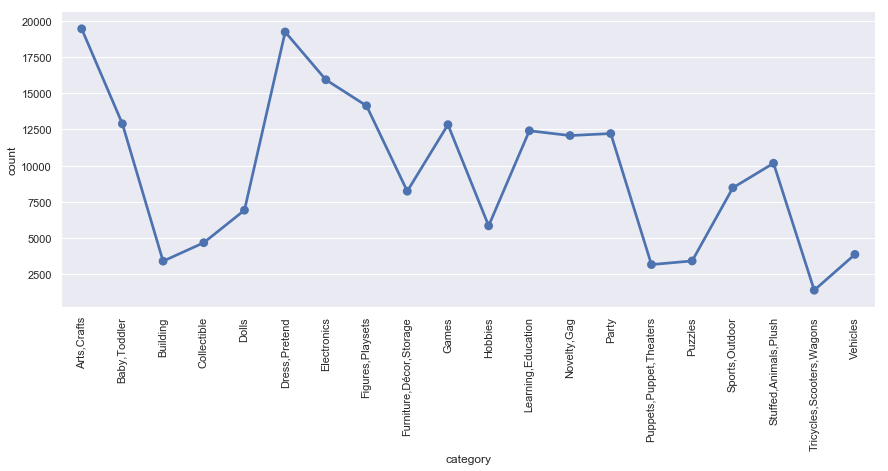

In [186]:
# Toy categories that are most popular during November (Arts & Crafts, Dolls, Electronics)
# main most popular toy categories stays the same as in January and December plus we can see increased popularity for 
# the category of Dress,Pretend as a result of halloween(October 31) 
fig_november = sns.factorplot('category','count', data=november, aspect = 2.5, );
fig_november.set_xticklabels(rotation=90)

In [187]:
# Summary:  As we can see, the most popular toy categories in the period of holidays and sales stay consistent.
# Games, Arts & Crafts, Electronics, Figures & Playsets
# the number of reviews for these toy categories fluctuating. the months that are getting most reviews
# January and December are months that getting most reviews

In [188]:
# Let's build plot for top categories Games, Arts & Crafts, Electronics, Figures & Playsets results by month
top_categories = review_data2.loc[(review_data2['category'] == 'Games') | (review_data2['category'] == 'Electronics')|(review_data2['category'] == 'Arts,Crafts')|(review_data2['category'] == 'Figures,Playsets')]

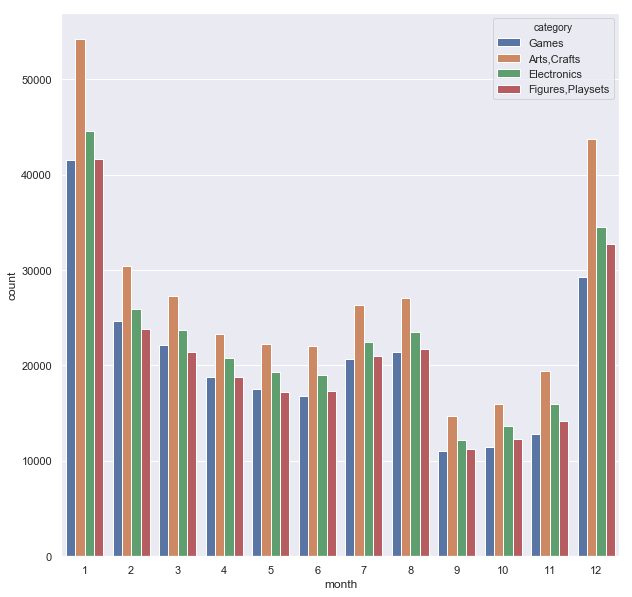

In [189]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.countplot(x="month", hue="category", data=top_categories, ax=ax)

In [190]:
# Let's look at toys that most popular at Arts & Crafts
arts_crafts = review_data2.loc[review_data2['category'] == 'Arts,Crafts']

In [191]:
arts_crafts = arts_crafts[['category','product_title']].groupby(['product_title']).size().reset_index().\
    rename(columns={0: 'count'})

In [192]:
arts_crafts = arts_crafts.sort_values(by=['count'], ascending=False)

In [193]:
# Top 10 product in a Arts & Crafts toy category
arts_crafts.head(10)

,product_title,count
23086,Melissa & Doug,9947
26100,Moon In My Room Remote Control Wall Décor Nigh...,1405
31740,Rubie's V for Vendetta Mask,1123
23103,Melissa & Doug - Lifelike Stuffed Animal,1021
18550,"Intex River Run I Sport Lounge, Inflatable Wat...",1021
25063,Melissa & Doug Suspend Family Game (31 pcs),1003
13198,Elf on the Shelf: A Christmas Tradition (blue-...,997
24886,Melissa & Doug Standard Unit Solid-Wood Buildi...,961
32680,Schylling Jack In The Box,961
23634,Melissa & Doug Deluxe Standing Easel,911


In [194]:
# Let's look at toys that most popular at Electronics
electronics = review_data2.loc[review_data2['category'] == 'Electronics']

In [195]:
electronics = electronics[['category','product_title']].groupby(['product_title']).size().reset_index().\
    rename(columns={0: 'count'})

In [196]:
electronics = electronics.sort_values(by=['count'], ascending=False)

In [197]:
# Top 10 product in a Electronics for Kids toy category
electronics.head(10)

,product_title,count
37633,UDI U818A 2.4GHz 4 CH 6 Axis Gyro RC Quadcopte...,2227
34882,Syma X5C Explorers 2.4G 4CH 6-Axis Gyro RC Qua...,1309
19049,InnoTab 3 Plus The Learning Tablet,1221
4713,Air Swimmers Remote Control Flying Shark,919
29433,Radio Flyer 4-in-1 Stroll 'N Trike,857
18804,Hubsan X4 H107C 4 Channel 2.4GHz RC Quad Copte...,775
17661,Handheld Brass Pirate Navigation Telescope wit...,732
34805,Syma S107/S107G 3 Channel RC Heli with Gyro - ...,721
32010,"SYMA X1 4 Channel 2.4G RC Quad Copter, Spacecr...",720
29430,Radio Flyer 32 All-Terrain Steel and Wood Wagon,666


In [198]:
# Let's look at toys that most popular at Figures & Playsets category 
figures = review_data2.loc[review_data2['category'] == 'Figures,Playsets']

In [199]:
figures = figures[['category','product_title']].groupby(['product_title']).size().reset_index().\
    rename(columns={0: 'count'})

In [200]:
figures = figures.sort_values(by=['count'], ascending=False)

In [201]:
# Top 10 product in a Figures & Playsets toy category
figures.head(10)

,product_title,count
18849,Little Tikes EasyScore Basketball Set,1714
22063,Minecraft Action Figures with Accessory,1473
27892,Schylling Junior Helper Broom Set,1406
18868,Little Tikes TotSports T-Ball Set,1139
8352,Disney Advanced Talking Buzz Lightyear Action ...,1038
30322,Spirograph Set,1017
25204,Playskool Heroes Transformers Rescue Bots Ener...,943
25203,Playskool Heroes Transformers Rescue Bots Ener...,879
17738,LEGO Bricks & More Builders of Tomorrow Set 61...,842
25189,Playskool Heroes Transformers Rescue Bots Blad...,651


In [202]:
# Let's look at toys that most popular at Games category 
games = review_data2.loc[review_data2['category'] == 'Games']

In [203]:
games = games[['category','product_title']].groupby(['product_title']).size().reset_index().\
    rename(columns={0: 'count'})

In [204]:
games = games.sort_values(by=['count'], ascending=False)

In [205]:
# Top 10 product in a Collectible Card Games toy category
games.head(10)

,product_title,count
4553,Cards Against Humanity,23124
4581,Cards Against Humanity: First Expansion,5851
4583,Cards Against Humanity: Second Expansion,3838
4585,Cards Against Humanity: Third Expansion,2667
4582,Cards Against Humanity: Fourth Expansion,2236
14462,MindWare Qwirkle Tile Game,1595
4580,Cards Against Humanity: Fifth Expansion,1308
2635,Bananagrams Word Game,1081
12132,Jenga Hardwood Game,931
15914,Pandemic Board Game,876


In [206]:
# Cards Against Humanity most popular toy in a category Games

In [207]:
# Since we have Dress,Pretend Category category popular in November, let's look at toys that most popular in this category
costumes = review_data2.loc[review_data2['category'] == 'Dress,Pretend']

In [208]:
costumes = costumes[['category','product_title']].groupby(['product_title']).size().reset_index().\
    rename(columns={0: 'count'})

In [209]:
costumes = costumes.sort_values(by=['count'], ascending=False)

In [210]:
# Top 10 product in a Dress,Pretend Category toy category
costumes.head(10)

,product_title,count
6395,Disney Frozen Enchanting Elsa Dress,1127
6033,Disguise Girls Disney Frozen Elsa Deluxe Costume,963
2803,Butterfly Craze Girls Snow Queen Costume Snow ...,793
5742,Despicable Me Minions,648
5708,Despicable Me Minion Dave Talking Action Figure,639
5448,Despicable Me 2 Fart Blaster: A Despicable Min...,534
14567,Playhut Beauty Boutique Play Tent,523
11683,Leegoal(TM) Unicorn Horn Headband Flowers Ears...,489
6272,Disney FROZEN Travel Dress Up Trunk,454
8473,"Fisher-Price Grow with Me 1,2,3 Roller Skates",441


In [213]:
os.system('afplay /System/Library/Sounds/Submarine.aiff')

0